In [39]:
from src import *

In [40]:
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy import stats

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

## Table of Contents
- On static FC

- On Static Gradients


- On Dynamic Gradients


In [41]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())

## On Static FC

In [4]:
regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']


In [5]:
mri_path = "./data/fmri400_compiled/"
mri_df   = pd.read_csv(mri_path + "Rest_compiled.csv")

In [6]:
filenames = [mri_df[mri_df.id=='sub-'+s].iloc[0].filename for s in subjects]

In [12]:
subject_timeseries = {subjects[i]: df_to_timeseries(mri_df, filenames[i])[0]  for i in range(len(subjects))}
timeseries = [zscore(subject_timeseries[s].sum(axis=1)) for s in subjects]
timeseries = np.asarray(timeseries)

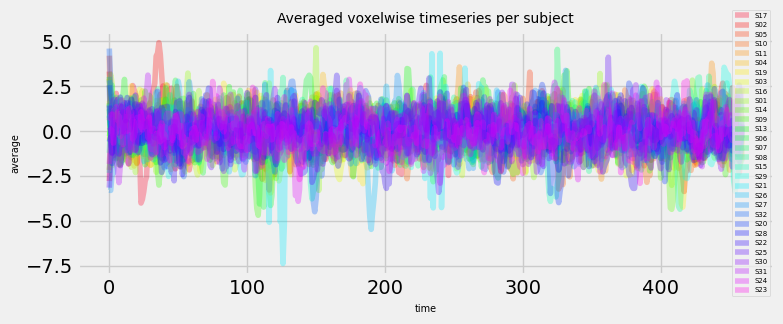

In [281]:
NUM_COLORS = len(subjects)
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for s in subjects:
    tmp = zscore(subject_timeseries[s].sum(axis=1))
    plt.plot(tmp, label=s, alpha=0.3)

ax.set_title('Averaged voxelwise timeseries per subject', size=10)
ax.set_xlabel('time', size=7)
ax.set_ylabel('average', size=7)
ax.legend(loc=7, prop={'size':5})
plt.show()

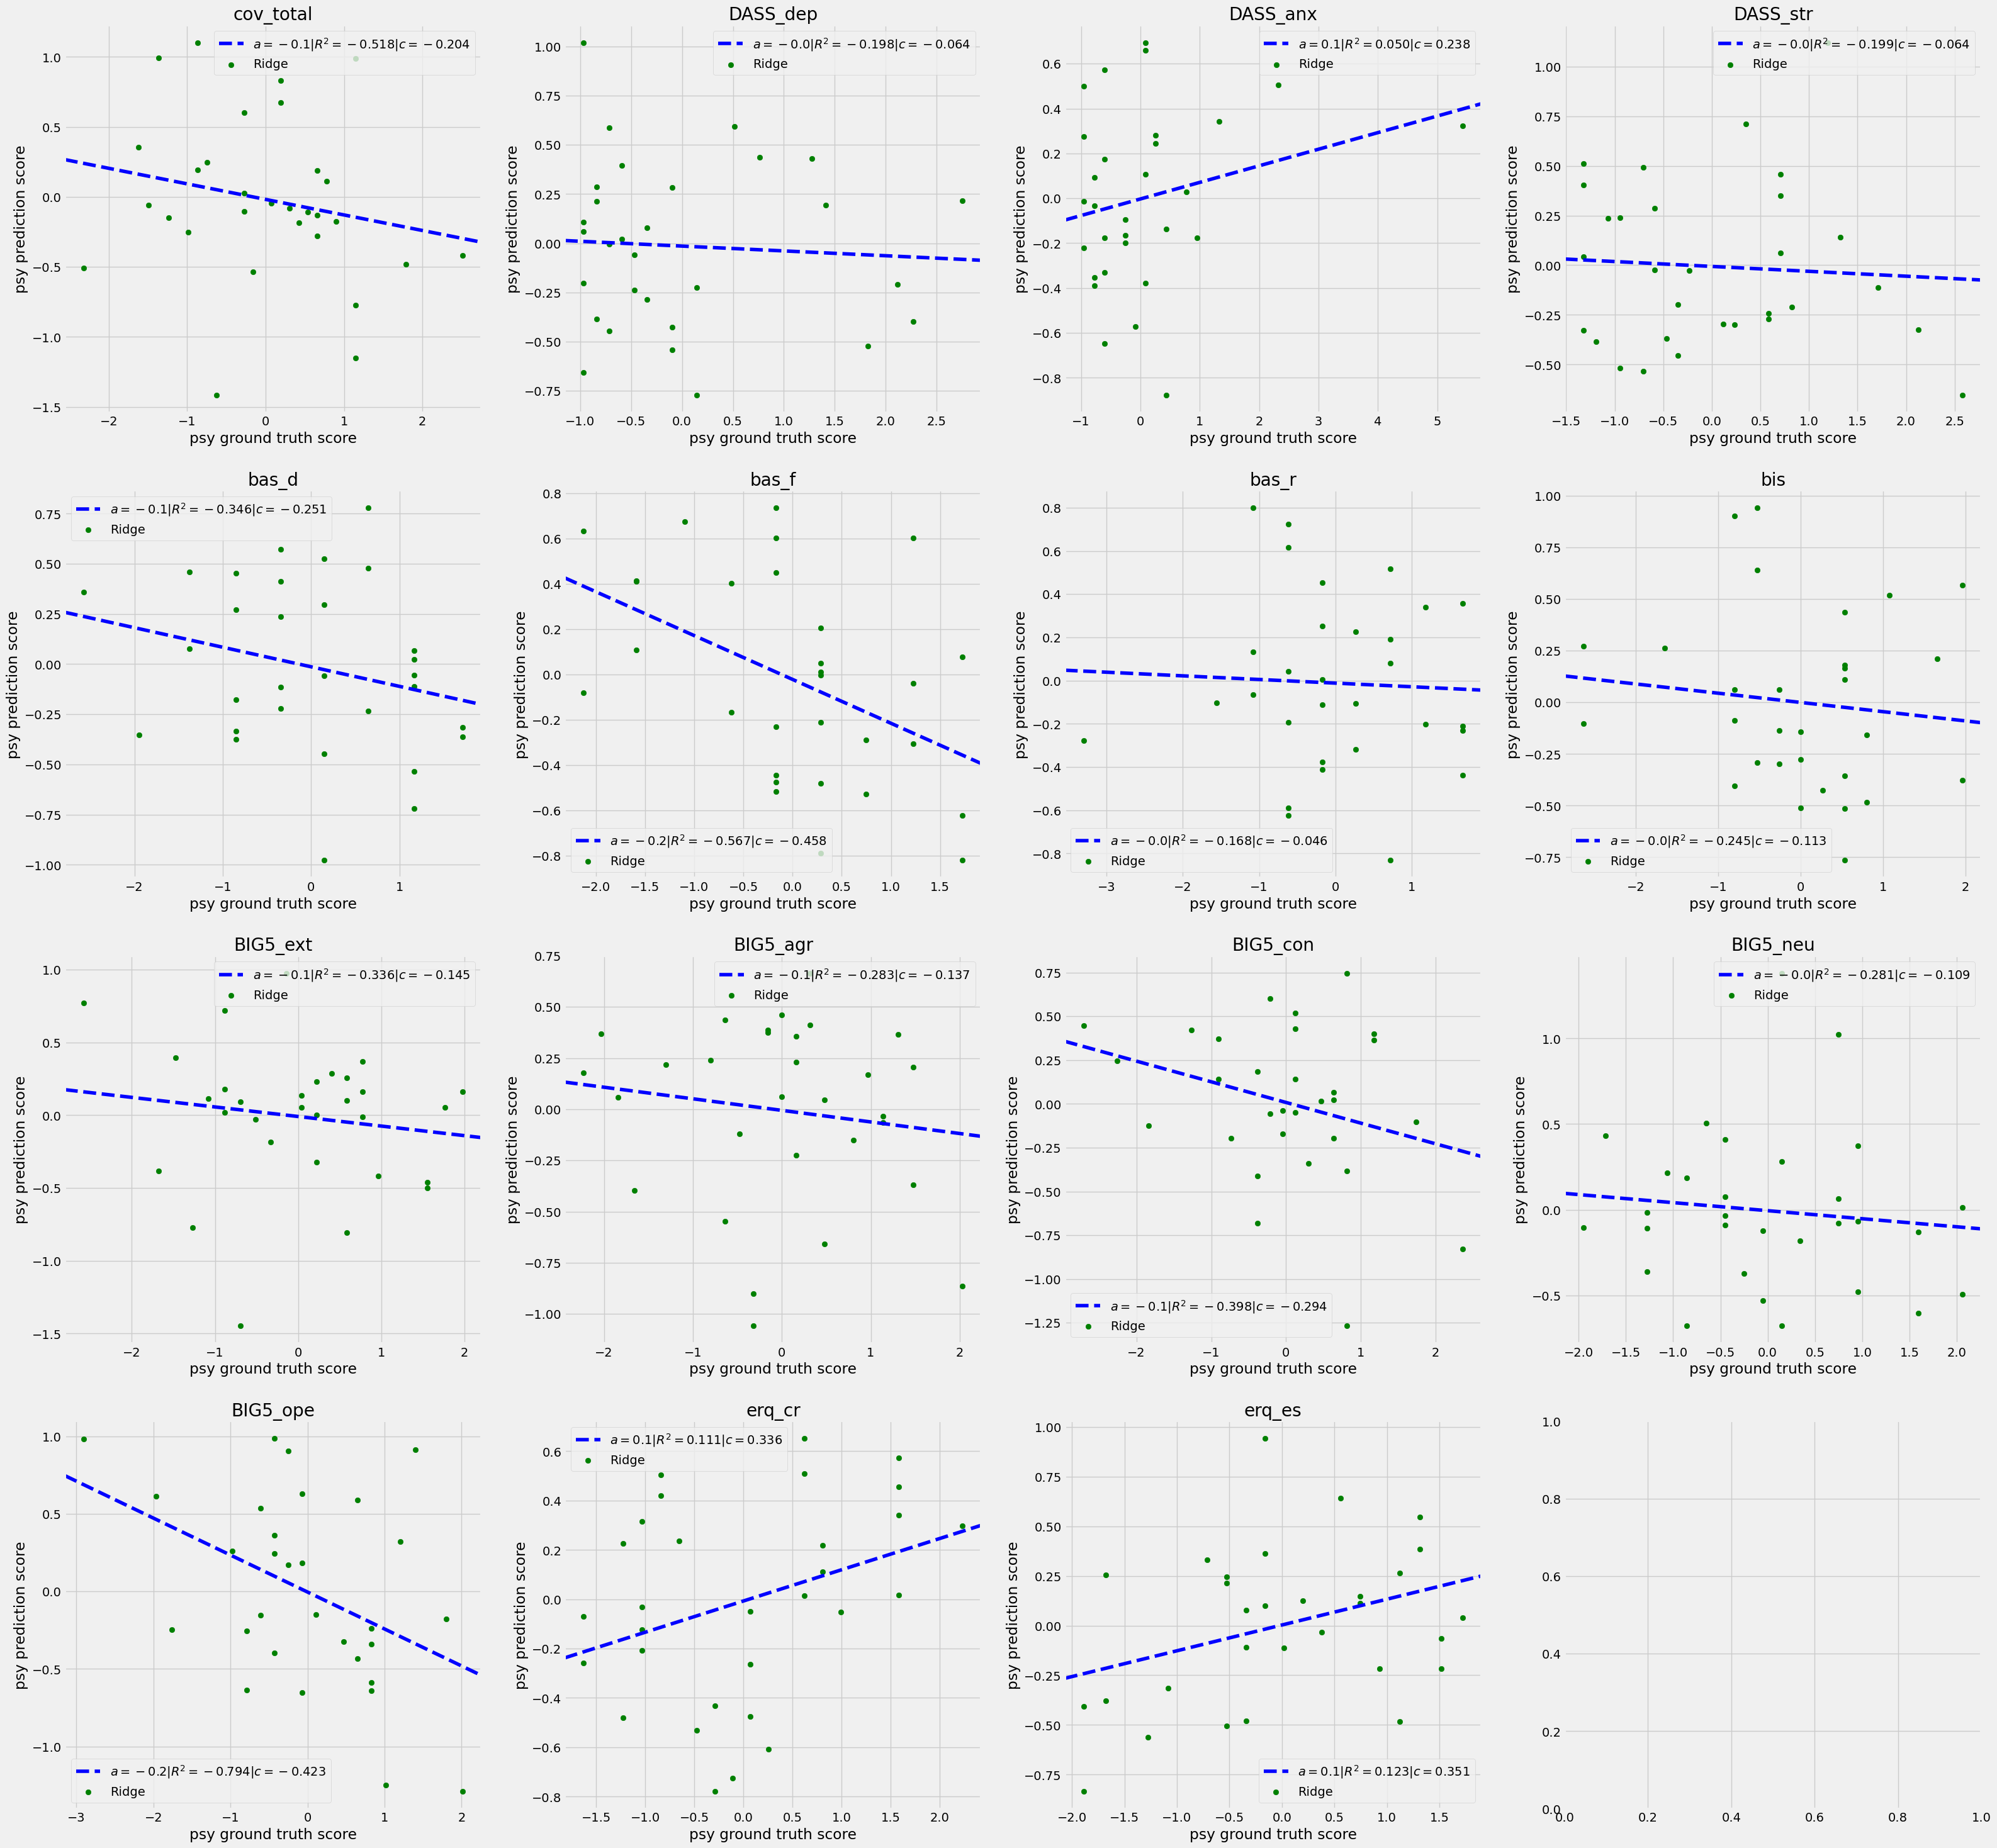

In [287]:
fig, ax = plt.subplots(4,4, figsize=(35,35))
corr_time = np.zeros((len(existing_psy)))
n = len(subjects)
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(n)]
    psyscore = np.array(psyscore)
    
    pts2 = []
    for j in range(n):

        clf  = Ridge(alpha=10)
        tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
        tmp2 = np.concatenate([timeseries[:j], timeseries[j+1:]])

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = timeseries[j]
        gt = (psyscore[j]-m)/s
    
        pts2.append([clf.predict([topredict])[0], gt])

    pts2 = np.asarray(pts2)
    r2   = r2_score(pts2[:,1],pts2[:,0])
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
    corr_time[i] = corr
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={corr:.3f}$', color='b')

    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

In [288]:
np.random.seed(99)
distribsC = []
n = len(psyscore)
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    
    null_distrib = []
    for _ in range(1000):
        np.random.shuffle(psyscore)
        pts2 = []
        for j in range(n):

            clf  = Ridge(alpha=10)
            tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
            tmp2 = np.concatenate([timeseries[:j], timeseries[j+1:]])

            y, m, s = zscore(tmp, ret_param=True)
            clf.fit(tmp2, y)

            topredict = timeseries[j]
            gt = (psyscore[j]-m)/s
        
            pts2.append([clf.predict([topredict])[0], gt])

        pts2 = np.asarray(pts2)
        corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
        null_distrib.append(corr)
    distribsC.append(null_distrib)

100%|██████████| 15/15 [03:08<00:00, 12.58s/it]


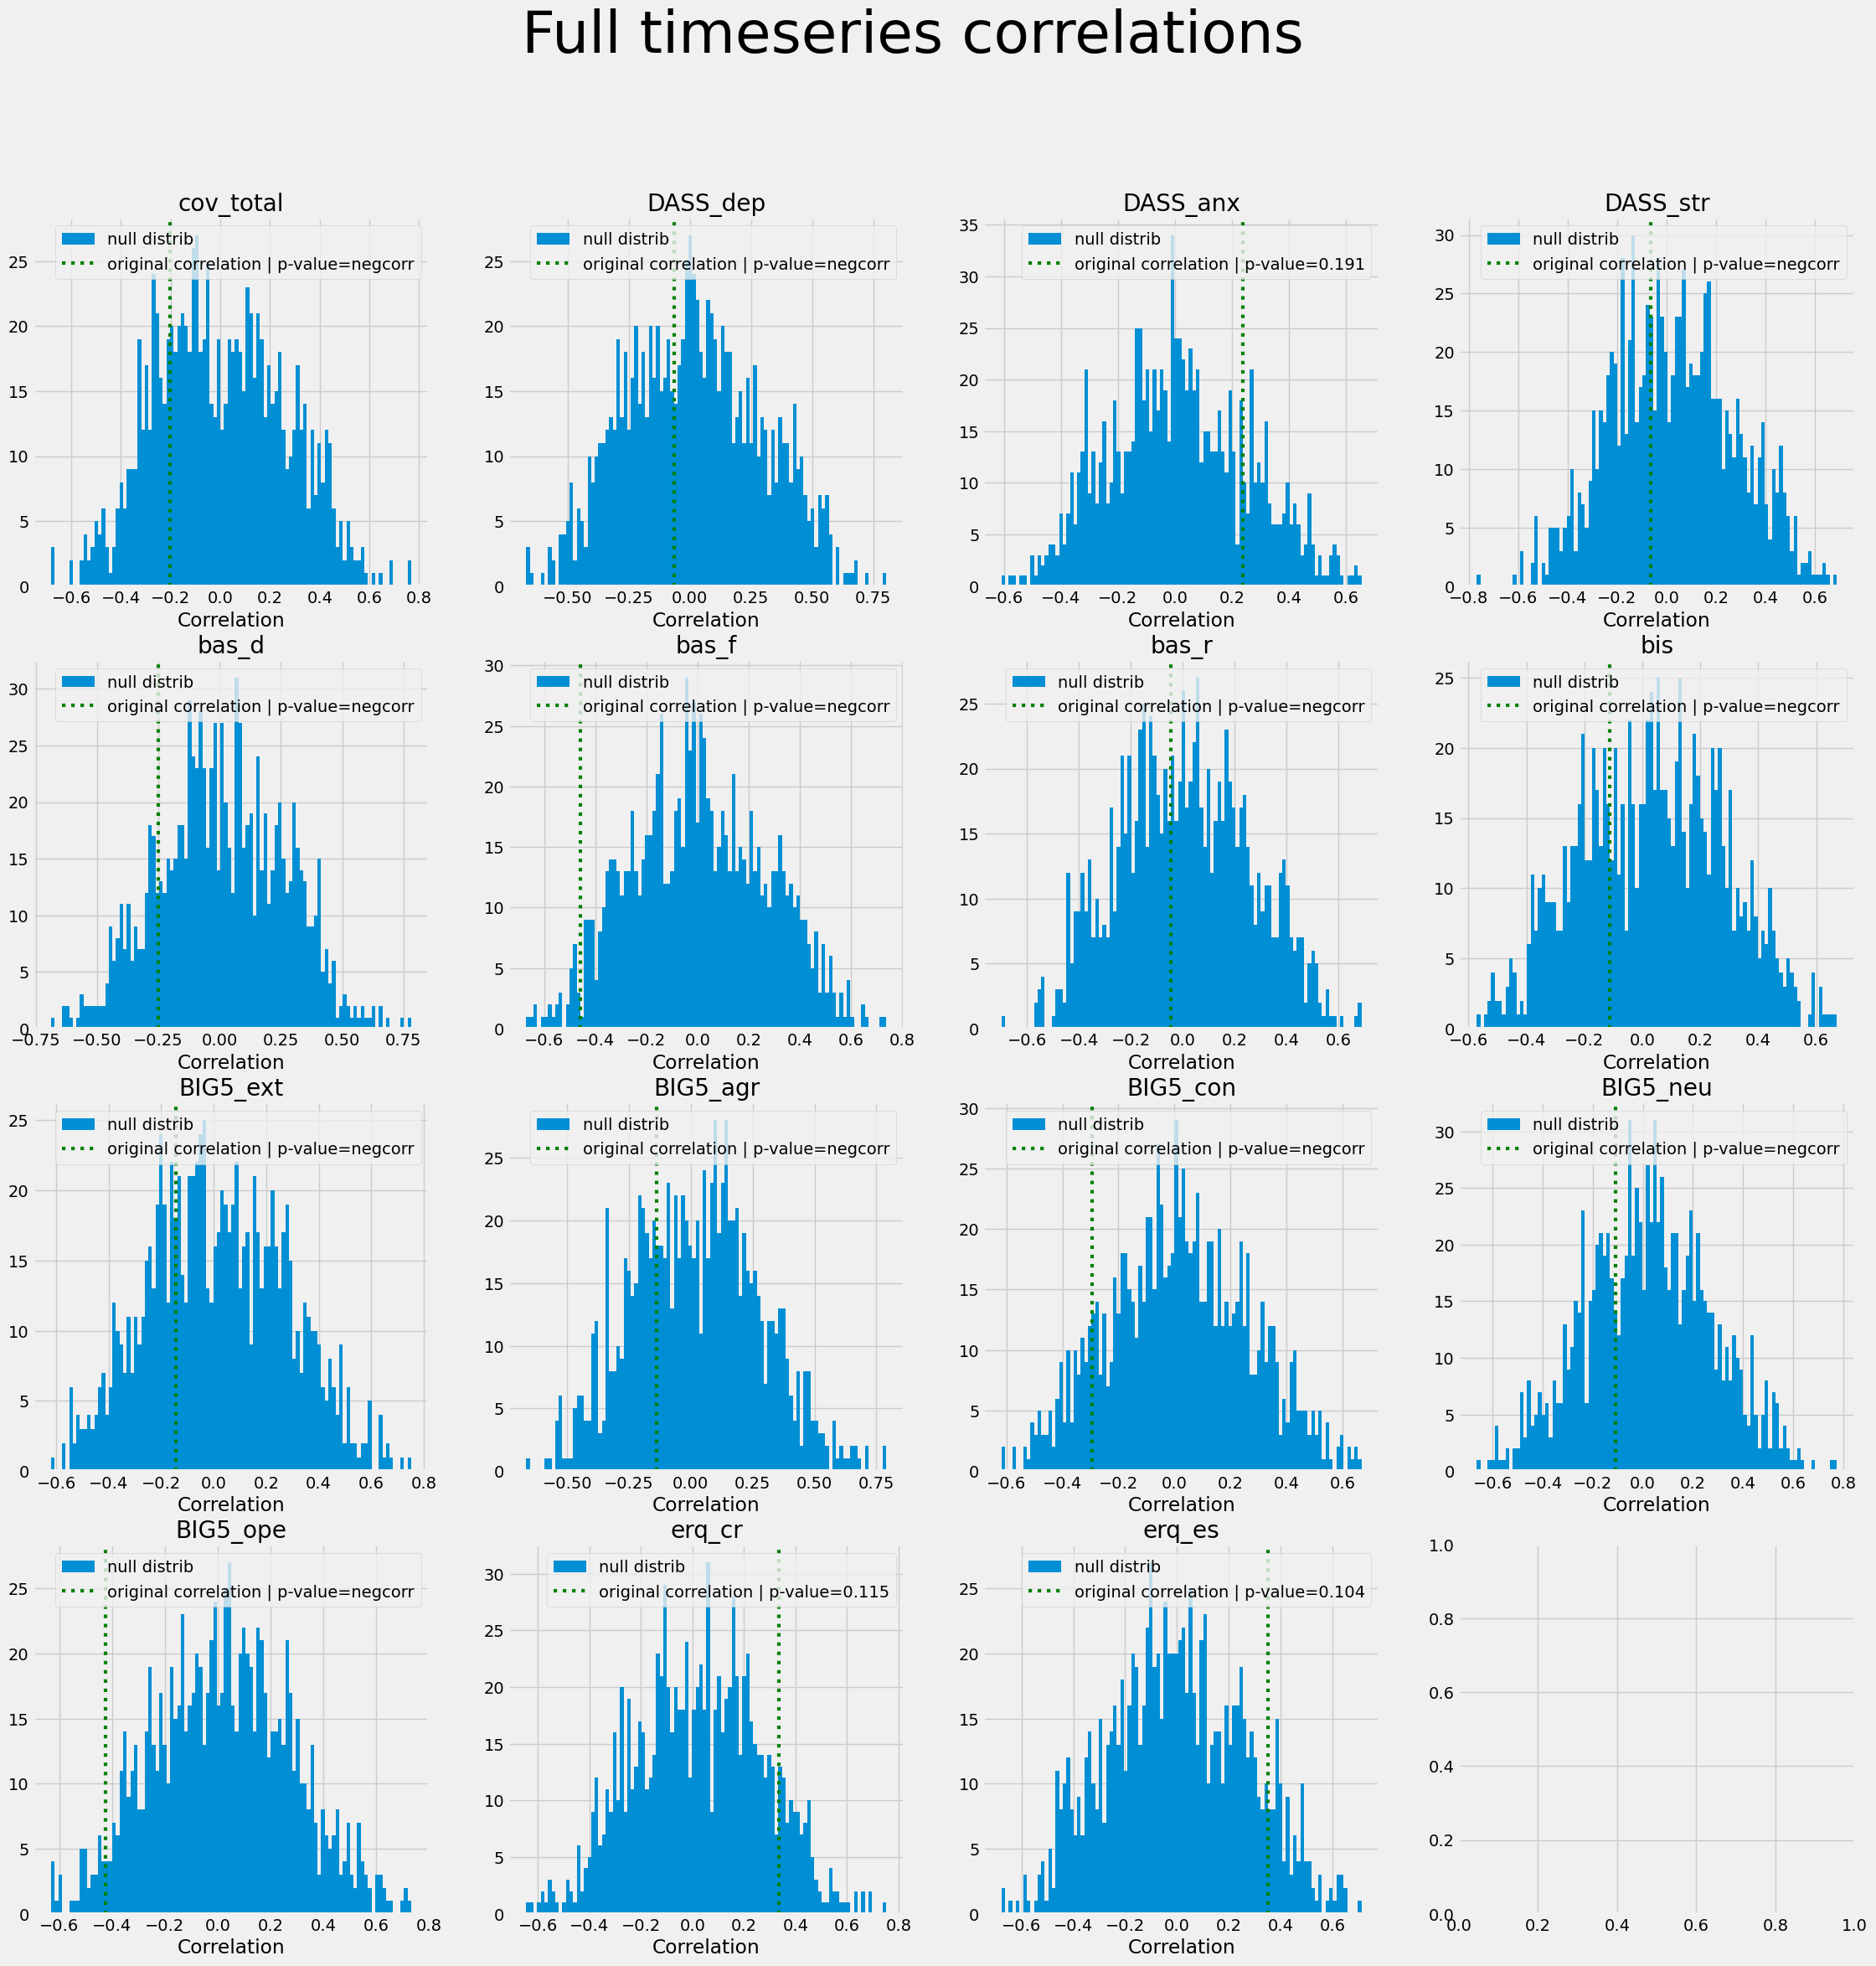

In [289]:
fig, ax = plt.subplots(4,4, figsize=(25,25))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    pval = null_score(distribsC[i], corr_time[i])
    ax[r,c].hist(distribsC[i], bins=100, label='null distrib')

    if corr_time[i] >= 0:
        ax[r,c].axvline(x=corr_time[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format(pval))
        nbstar = int(pval < 0.05) + int(pval < 0.1) + int(pval < 0.001)
        ax[r,c].set_title(feat + ' *'*nbstar)
    else:
        ax[r,c].axvline(x=corr_time[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format("negcorr"))
        ax[r,c].set_title(feat)

    ax[r,c].set_xlabel('Correlation')
    ax[r,c].legend()

plt.suptitle('Full timeseries correlations', size=50)
plt.show()

## On Static Gradients

In [42]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())
gradients = np.asarray([subject_grad[s] for s in subjects])

In [45]:
subjects     = list(subject_grad.keys())
regions      = list(index2region.keys())
print(subjects)
print(regions)

['S17', 'S02', 'S05', 'S10', 'S11', 'S04', 'S19', 'S03', 'S16', 'S01', 'S14', 'S09', 'S13', 'S06', 'S07', 'S08', 'S15', 'S29', 'S21', 'S26', 'S27', 'S32', 'S20', 'S28', 'S22', 'S25', 'S30', 'S31', 'S24', 'S23']
['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']


In [46]:
L = [subject_grad[s] for s in subjects]
aligned, _ , score = procrustes_align(L)
print(score)
subject_grad = {subjects[i]: aligned[i] for i in range(len(subjects))}

65.3493982936322


In [47]:
feat     = existing_psy[0]
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
order    = np.argsort(psyscore)
print(feat)

cov_total


In [48]:
# 1. Volume computing 
features = np.zeros((len(subjects), len(regions)))
for sidx in range(len(subjects)):
    for ridx in range(len(regions)):
        features[sidx, ridx] = network_volume(subject_grad[subjects[sidx]], regions[ridx])

gradients = np.asarray([subject_grad[s] for s in subjects])

# 2/3. Full gradients and variances
G1,G2,coloring = [],[],[]
V1,V2,c2       = [],[],[]

for i in order:
    G1 += list(gradients[i][:,0])
    G2 += list(gradients[i][:,1])
    coloring += [psyscore[i]] * 400
    
    V1 += [gradients[i][:,0].std()]
    V2 += [gradients[i][:,2].std()]
    c2 += [psyscore[i]]

#### Visual difference

In [49]:
# NUM_COLORS = len(features)
# cm = plt.get_cmap('gist_rainbow')
# fig = plt.figure(figsize=(8,3))
# ax = fig.add_subplot(111)
# ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

# for i in order:
#     plt.plot(features[i], label='subj{}: {}'.format(i, psyscore[i]), linewidth=2)

# plt.title('Network volumes across subjects', size=10)
# plt.xlabel('Network number', size=7)
# plt.ylabel('Volume', size=7)
# plt.legend(loc=5, prop={'size':4})
# plt.show()

Text(25.09722222222222, 0.5, 'G2')

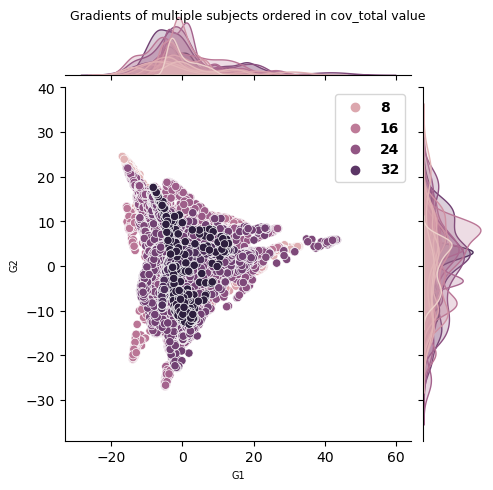

In [50]:
tmp_df = {"G1": G1 , "G2": G2, feat: coloring}

ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue=feat, height=5)
ax.fig.suptitle("Gradients of multiple subjects ordered in {} value".format(feat), size=9)
legend_properties = {'weight':'bold','size':10}
ax.ax_joint.legend(prop=legend_properties,loc='upper right')
ax.ax_joint.set_xlabel('G1', size=7)
ax.ax_joint.set_ylabel('G2', size=7)

In [12]:
# correlation of first 5 gradients per parcel value with persontality index

gradpsycorr = np.zeros((15,gradients.shape[1]))
for i in range(15):
    feat = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    
    for k in range(gradients.shape[1]):
        tmp1 = zscore(gradients[:,k,0])
        tmp2 = zscore(np.array(psyscore))
        corr = stats.pearsonr(tmp1, tmp2).statistic
        gradpsycorr[i][k] = corr

First gradient


/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


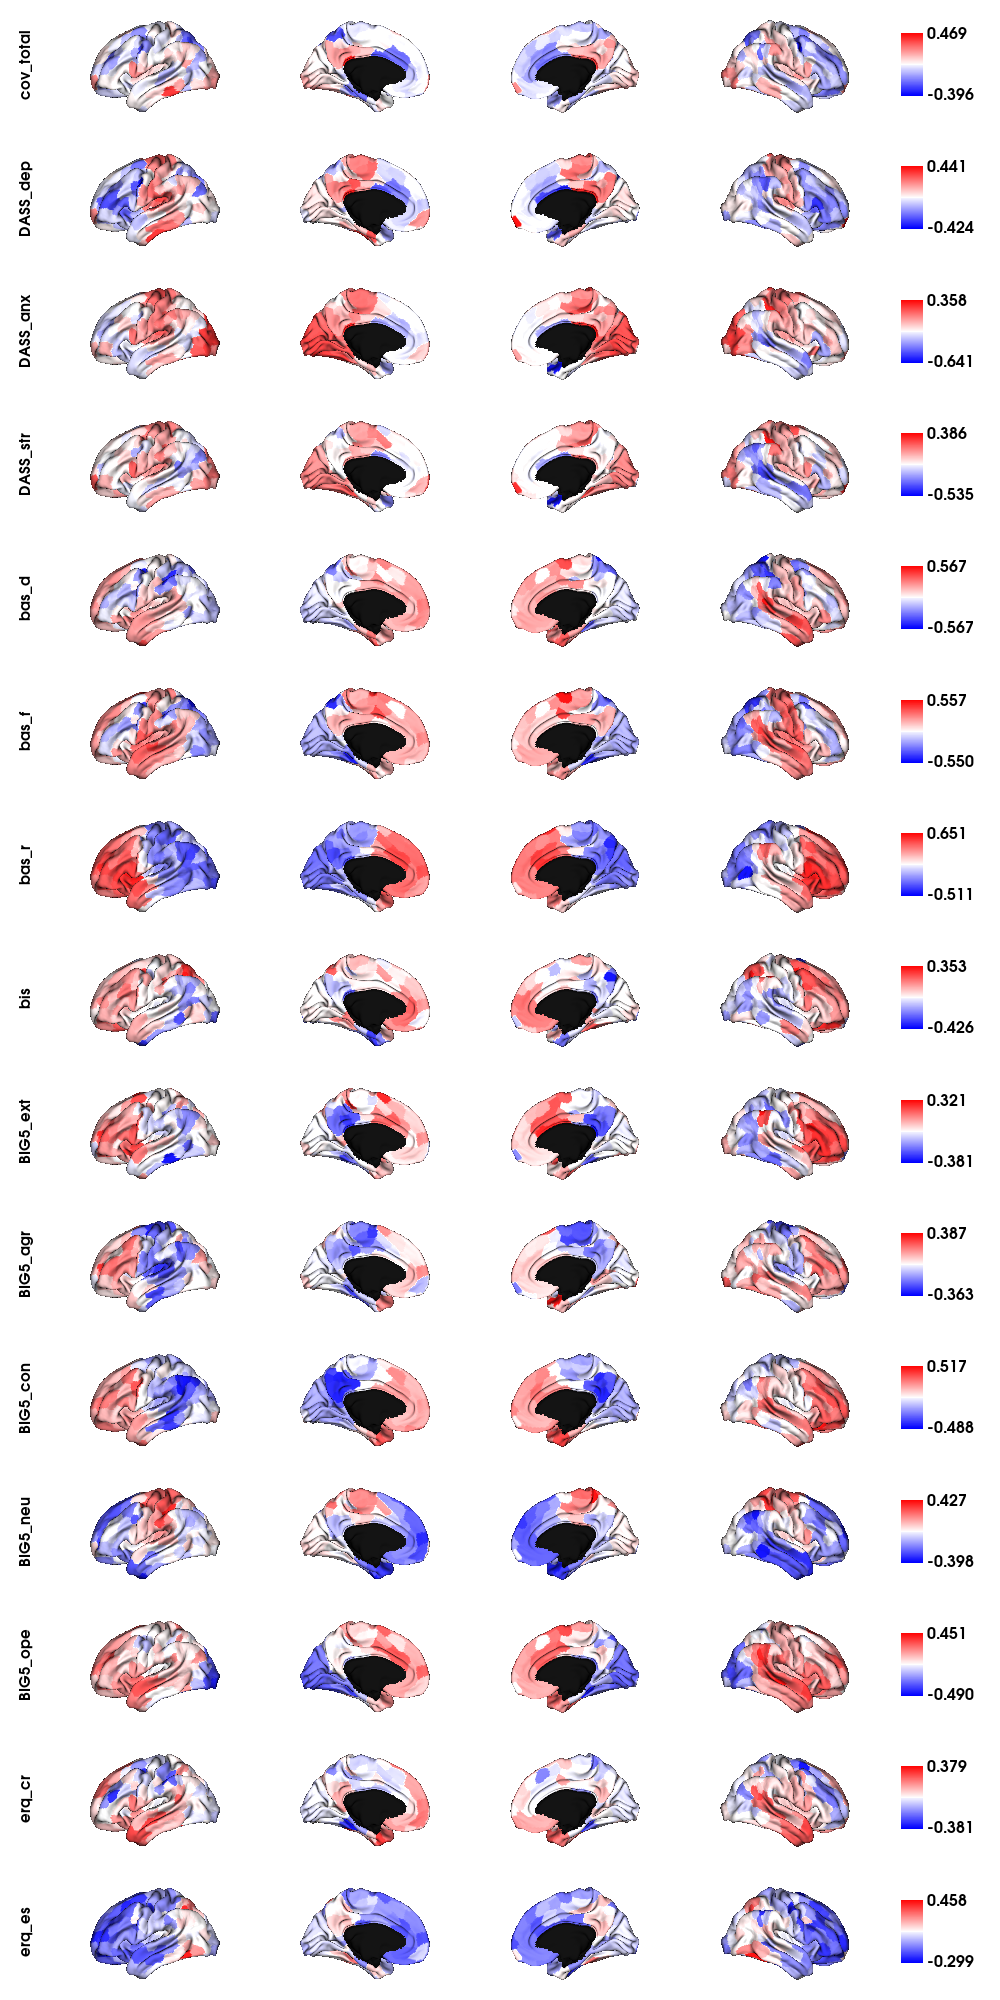

In [13]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
grad = [None] * 15
for i in range(15):
    # map the gradient to the parcels
    grad[i] = map_to_labels(gradpsycorr[i], labeling, mask=mask, fill=np.nan)

print('First gradient')
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='bwr',
                 color_bar=True, label_text=existing_psy, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)

### Regress / Predictive

#### Ridge on Full gradients (3 gradients)

100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


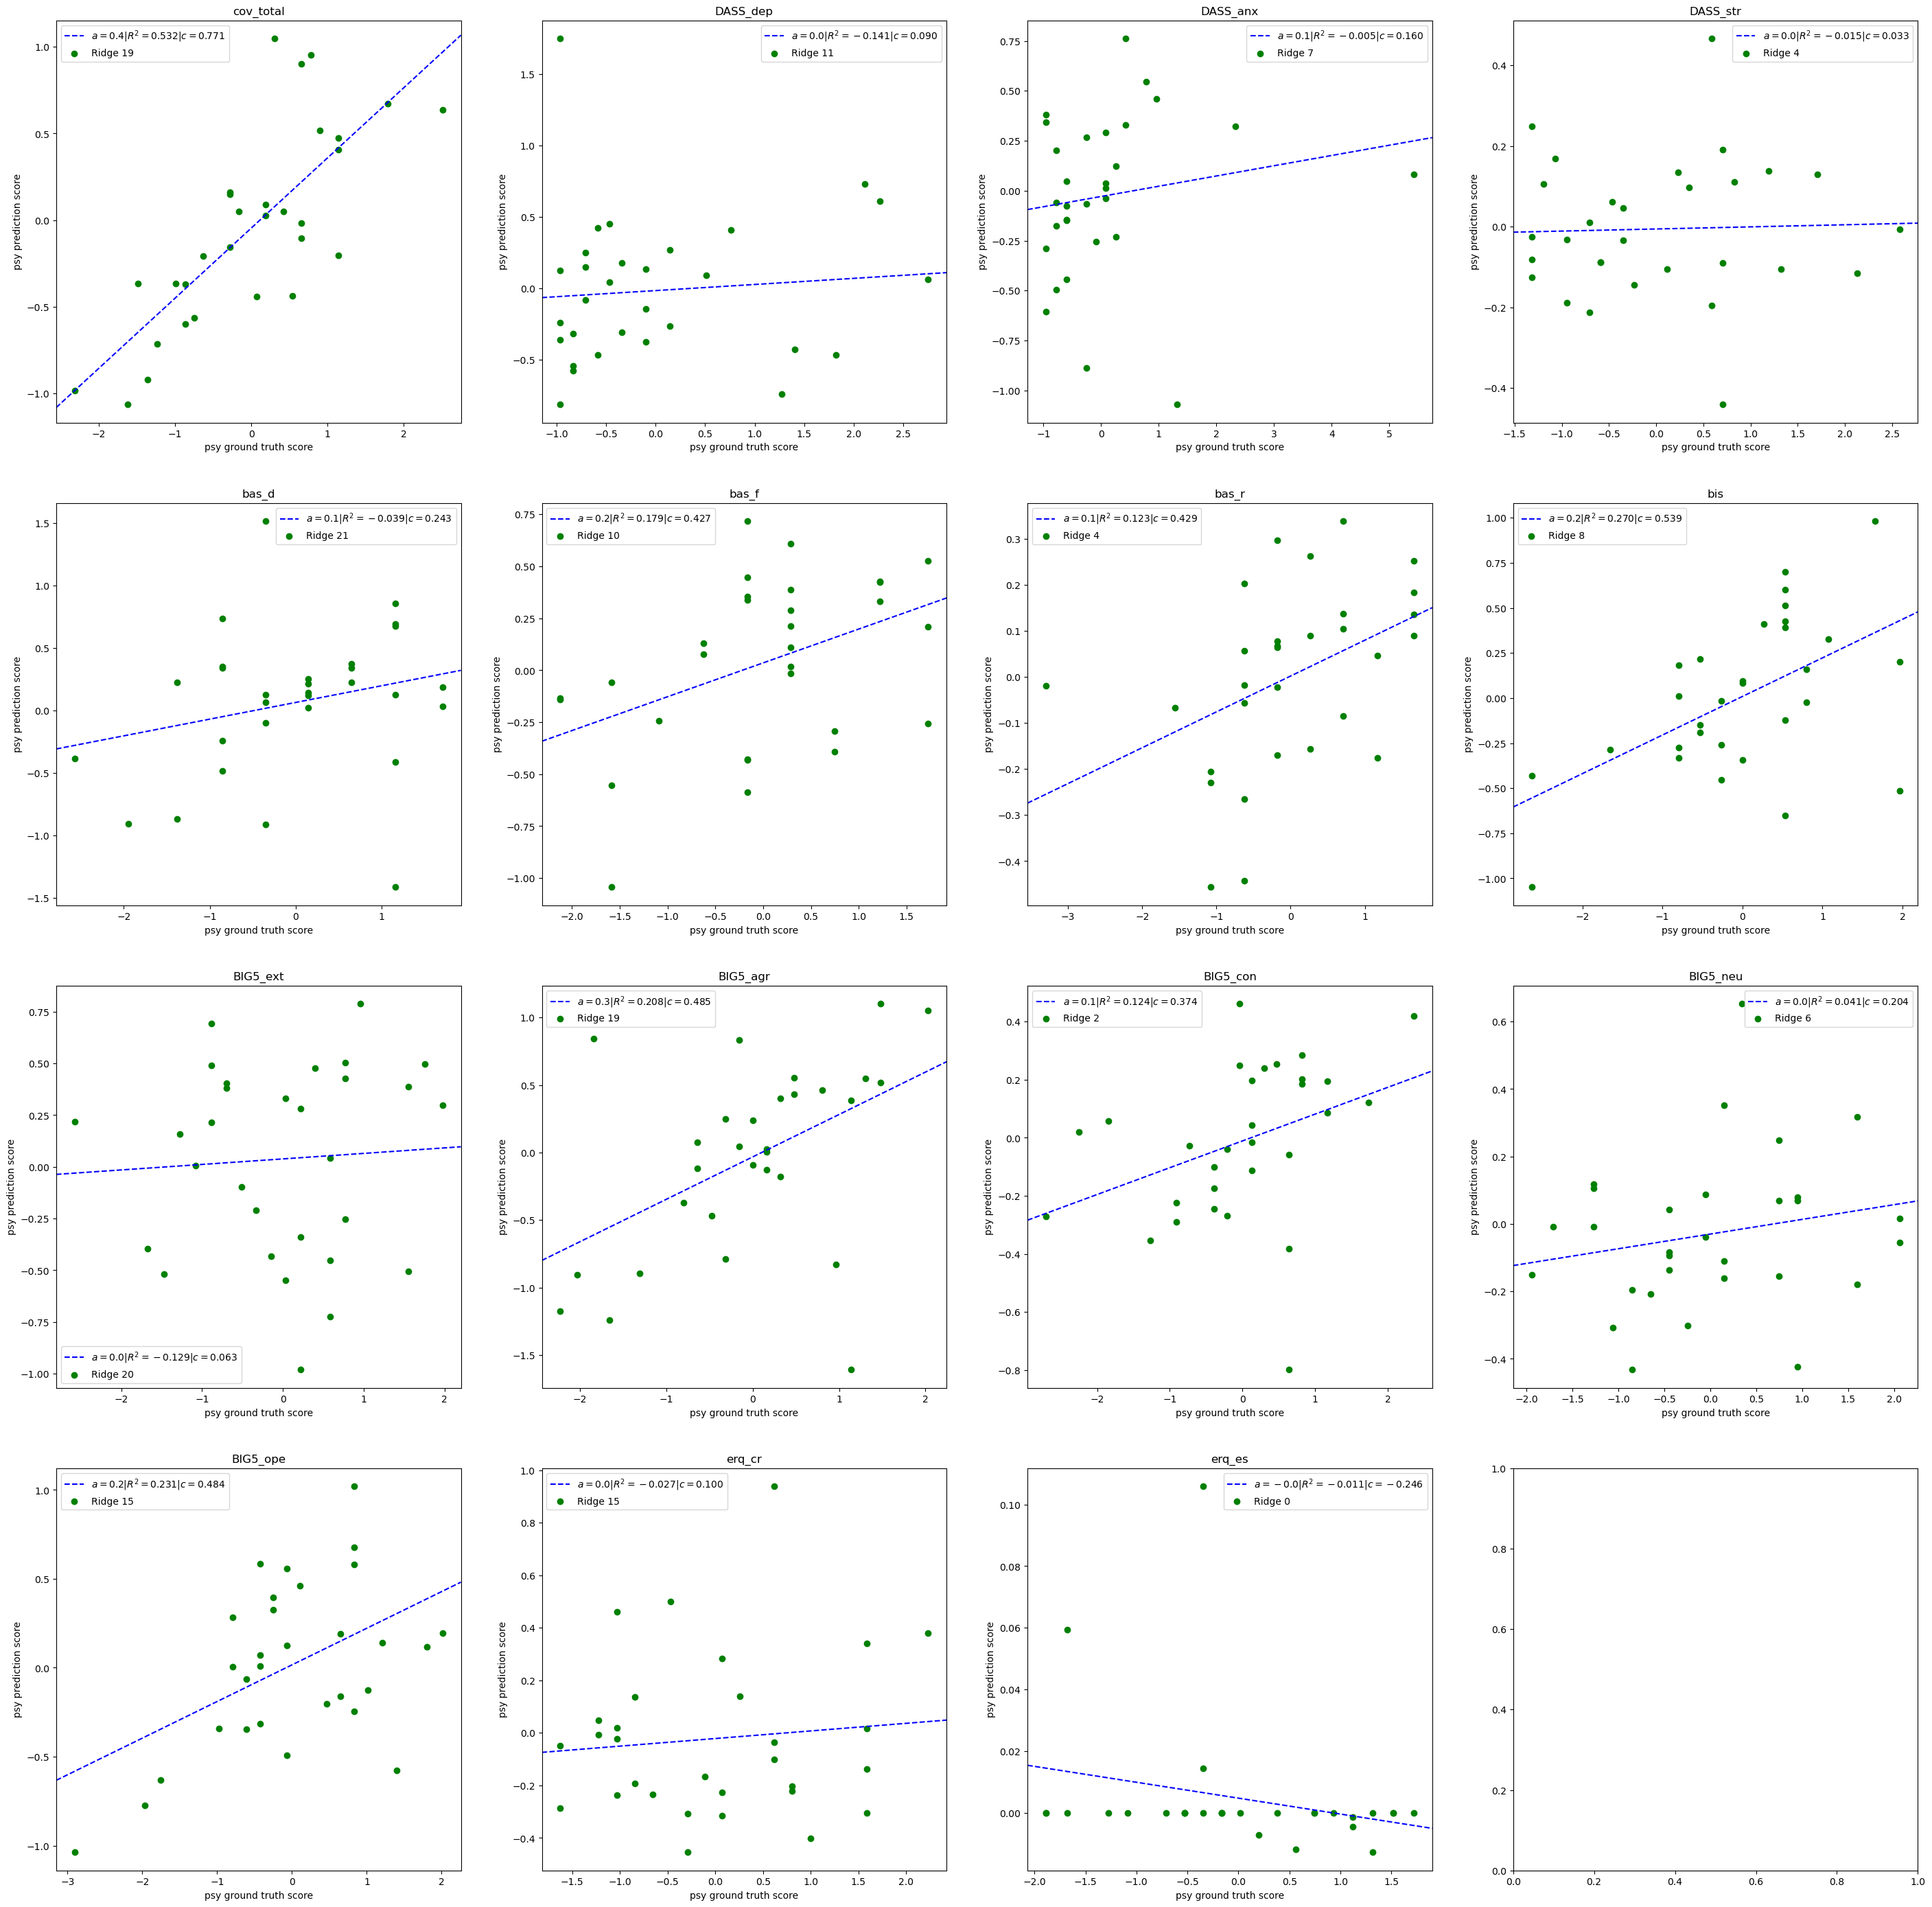

In [67]:
logs = {}
lambdas = [0.5,1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)

fig, ax = plt.subplots(4,4, figsize=(35,35))


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    psyscore = np.array(psyscore)

    best_corr = -1
    pts = []
    for a in lambdas:
        clf  = Lasso(alpha=a)
        # leave one out val prediction score    
        pts2 = []
        for j in range(len(psyscore)):

            
            # select number of percentile
            tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
            tmp2 = np.concatenate([A[:j], A[j+1:]])

            y, m, s = zscore(tmp, ret_param=True)
            clf.fit(tmp2, y)

            topredict = A[j]
            gt = (psyscore[j]-m)/s

            pts2.append([clf.predict([topredict])[0], gt])
            
        pts2 = np.asarray(pts2)

        cur_corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
        if cur_corr > best_corr:
            best_corr = cur_corr
            pts = deepcopy(pts2)
            logs[feat] = clf.coef_

        # we log the coefficients and as well the 
        
    r2 = r2_score(pts[:,1],pts[:,0])
    m2, b2 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={best_corr:.3f}$', color='b')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='g', label="Ridge {}".format(np.sum(logs[feat] != 0)))

    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

#### Ridge on Full gradients (3 gradients) with k-fold

In [14]:
import warnings
warnings.filterwarnings("ignore")

With One given Movie

In [15]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Sintel_grad.pkl')
subjects     = list(subject_grad.keys())
gradients = np.asarray([subject_grad[s] for s in subjects])

In [28]:
np.random.seed(10)

logs = {existing_psy[i]: [] for i in range(len(existing_psy))}
lambdas = [1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    psyscore = np.array(psyscore)

    # repeat fold combinations
    for k in range(200):
        best_corr = -1
        best_coef = None
        for a in lambdas:
            avg = []
            # fold defining
            splits = np.random.choice(np.arange(len(psyscore)),replace=False, size=(5,6))
            for j in range(5):
                clf  = Lasso(alpha=a)
                val   = splits[j]
                train = np.array(list(set(np.arange(len(psyscore))) - set(val)))

                tmp  = psyscore[train]
                tmp2 = A[train]

                y, m, s = zscore(tmp, ret_param=True)
                clf.fit(tmp2, y)

                topredict = A[val]
                gt = (psyscore[val]-m)/s

                avg.append(stats.pearsonr(clf.predict(topredict), gt).statistic)
            
            cur_corr = np.mean(avg)

            if cur_corr > best_corr:
                best_corr = cur_corr
                best_coef = clf.coef_

        logs[feat].append([best_corr, best_coef])

100%|██████████| 15/15 [08:48<00:00, 35.22s/it]


In [29]:
np.random.seed(10)

logsnull = {existing_psy[i]: [] for i in range(len(existing_psy))}
lambdas = [1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    # repeat fold combinations with different shuffled ground truth
    for k in range(500):
        psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
        psyscore = np.array(psyscore)
        np.random.shuffle(psyscore)
        best_corr = -1
        best_coef = None
        for a in lambdas:
            avg = []
            # fold defining
            splits = np.random.choice(np.arange(len(psyscore)),replace=False, size=(5,6))
            for j in range(5):
                clf   = Lasso(alpha=a)
                val   = splits[j]
                train = np.array(list(set(np.arange(len(psyscore))) - set(val)))

                tmp  = psyscore[train]
                tmp2 = A[train]

                y, m, s = zscore(tmp, ret_param=True)
                clf.fit(tmp2, y)

                topredict = A[val]
                gt = (psyscore[val]-m)/s

                avg.append(stats.pearsonr(clf.predict(topredict), gt).statistic)
            
            cur_corr = np.mean(avg)

            if cur_corr > best_corr:
                best_corr = cur_corr
                best_coef = clf.coef_

        logsnull[feat].append([best_corr, best_coef])

100%|██████████| 15/15 [25:50<00:00, 103.37s/it]


In [30]:
row1 = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r']
row2 = ['bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row1:
    folds = np.asarray(logs[r])[:,0].astype(float)
    foldsN = np.asarray(logsnull[r])[:,0].astype(float)
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]


pred_distrib2 = {'pidx': [], 'foldcorr': []}
null_distrib2 = {'pidx': [], 'foldcorr': []}
for r in row2:
    folds = np.asarray(logs[r])[:,0].astype(float)
    foldsN = np.asarray(logsnull[r])[:,0].astype(float)
    pred_distrib2['foldcorr'] += list(folds)
    pred_distrib2['pidx'] += len(folds) * [r]
    null_distrib2['foldcorr'] += list(foldsN)
    null_distrib2['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)
pred_distrib2 = pd.DataFrame.from_dict(pred_distrib2)
null_distrib2 = pd.DataFrame.from_dict(null_distrib2)

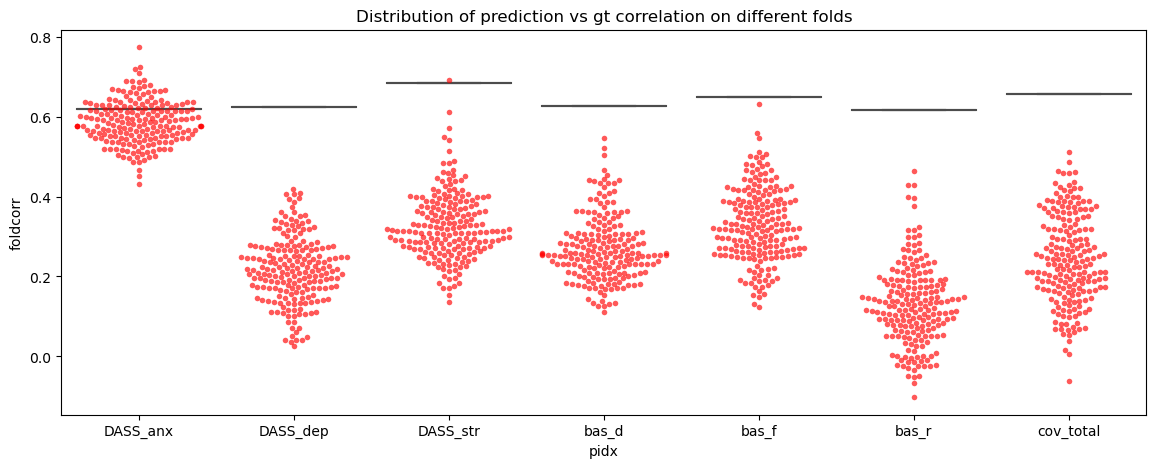

In [31]:
pal = sns.color_palette('hsv', len(row1))
plt.figure(figsize=(14,5))
# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib, capsize=0.001, errorbar="sd", palette=pal, alpha=0.3)
sns.boxplot(x="pidx", y="foldcorr", data=null_distrib.groupby('pidx').quantile(0.95).reset_index(), palette=pal)
sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib, color="r", alpha=.65, size=4)
# sns.swarmplot(x="pidx", y="foldcorr", data=null_distrib, color="b", alpha=.65, size=4)
plt.title("Distribution of prediction vs gt correlation on different folds")
plt.show()

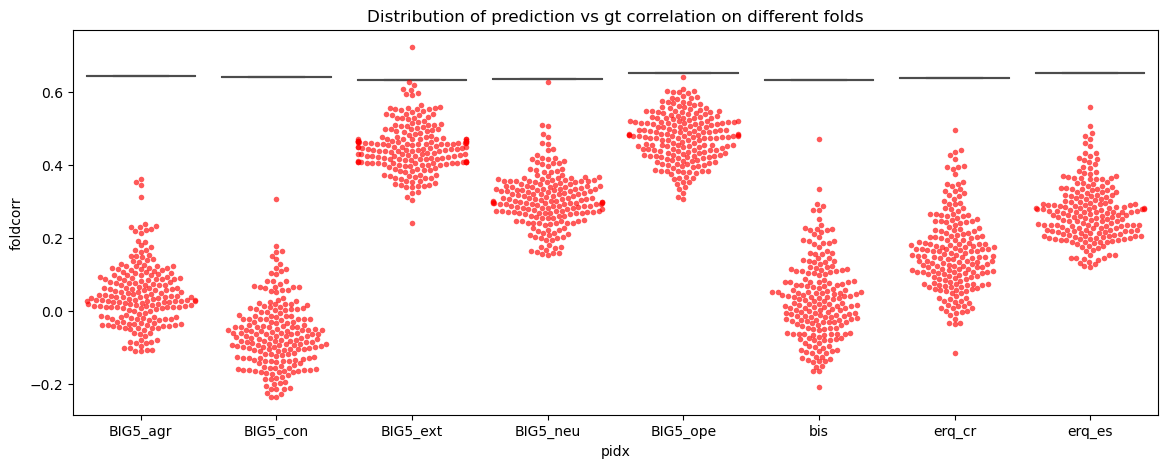

In [32]:
pal = sns.color_palette('hsv', len(row1))
plt.figure(figsize=(14,5))
# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib, capsize=0.001, errorbar="sd", palette=pal, alpha=0.3)
sns.boxplot(x="pidx", y="foldcorr", data=null_distrib2.groupby('pidx').quantile(0.95).reset_index(), palette=pal)
sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib2, color="r", alpha=.65, size=4)
# sns.swarmplot(x="pidx", y="foldcorr", data=null_distrib, color="b", alpha=.65, size=4)
plt.title("Distribution of prediction vs gt correlation on different folds")
plt.show()

With Rest

In [33]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())
gradients = np.asarray([subject_grad[s] for s in subjects])

In [34]:
np.random.seed(10)

logs = {existing_psy[i]: [] for i in range(len(existing_psy))}
lambdas = [1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    psyscore = np.array(psyscore)

    # repeat fold combinations
    for k in range(200):
        best_corr = -1
        best_coef = None
        for a in lambdas:
            avg = []
            # fold defining
            splits = np.random.choice(np.arange(len(psyscore)),replace=False, size=(5,6))
            for j in range(5):
                clf  = Lasso(alpha=a)
                val   = splits[j]
                train = np.array(list(set(np.arange(len(psyscore))) - set(val)))

                tmp  = psyscore[train]
                tmp2 = A[train]

                y, m, s = zscore(tmp, ret_param=True)
                clf.fit(tmp2, y)

                topredict = A[val]
                gt = (psyscore[val]-m)/s

                avg.append(stats.pearsonr(clf.predict(topredict), gt).statistic)
            
            cur_corr = np.mean(avg)

            if cur_corr > best_corr:
                best_corr = cur_corr
                best_coef = clf.coef_

        logs[feat].append([best_corr, best_coef])

100%|██████████| 15/15 [12:16<00:00, 49.13s/it]


In [35]:
np.random.seed(10)

logsnull = {existing_psy[i]: [] for i in range(len(existing_psy))}
lambdas = [1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    # repeat fold combinations with different shuffled ground truth
    for k in range(500):
        psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
        psyscore = np.array(psyscore)
        np.random.shuffle(psyscore)
        best_corr = -1
        best_coef = None
        for a in lambdas:
            avg = []
            # fold defining
            splits = np.random.choice(np.arange(len(psyscore)),replace=False, size=(5,6))
            for j in range(5):
                clf   = Lasso(alpha=a)
                val   = splits[j]
                train = np.array(list(set(np.arange(len(psyscore))) - set(val)))

                tmp  = psyscore[train]
                tmp2 = A[train]

                y, m, s = zscore(tmp, ret_param=True)
                clf.fit(tmp2, y)

                topredict = A[val]
                gt = (psyscore[val]-m)/s

                avg.append(stats.pearsonr(clf.predict(topredict), gt).statistic)
            
            cur_corr = np.mean(avg)

            if cur_corr > best_corr:
                best_corr = cur_corr
                best_coef = clf.coef_

        logsnull[feat].append([best_corr, best_coef])

100%|██████████| 15/15 [37:30<00:00, 150.01s/it]


In [36]:
row1 = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r']
row2 = ['bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row1:
    folds = np.asarray(logs[r])[:,0].astype(float)
    foldsN = np.asarray(logsnull[r])[:,0].astype(float)
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]


pred_distrib2 = {'pidx': [], 'foldcorr': []}
null_distrib2 = {'pidx': [], 'foldcorr': []}
for r in row2:
    folds = np.asarray(logs[r])[:,0].astype(float)
    foldsN = np.asarray(logsnull[r])[:,0].astype(float)
    pred_distrib2['foldcorr'] += list(folds)
    pred_distrib2['pidx'] += len(folds) * [r]
    null_distrib2['foldcorr'] += list(foldsN)
    null_distrib2['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)
pred_distrib2 = pd.DataFrame.from_dict(pred_distrib2)
null_distrib2 = pd.DataFrame.from_dict(null_distrib2)

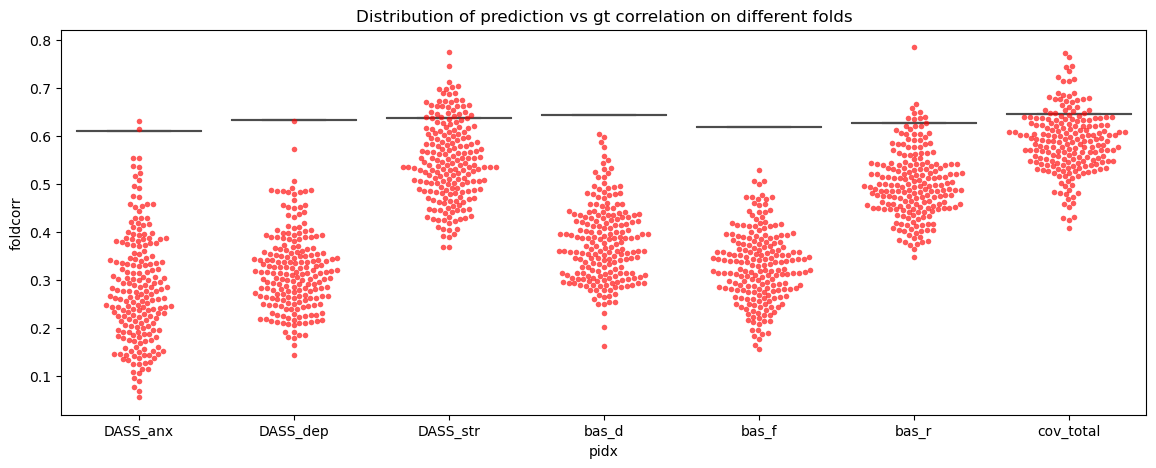

In [37]:
pal = sns.color_palette('hsv', len(row1))
plt.figure(figsize=(14,5))
# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib, capsize=0.001, errorbar="sd", palette=pal, alpha=0.3)
sns.boxplot(x="pidx", y="foldcorr", data=null_distrib.groupby('pidx').quantile(0.95).reset_index(), palette=pal)
sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib, color="r", alpha=.65, size=4)
# sns.swarmplot(x="pidx", y="foldcorr", data=null_distrib, color="b", alpha=.65, size=4)
plt.title("Distribution of prediction vs gt correlation on different folds")
plt.show()

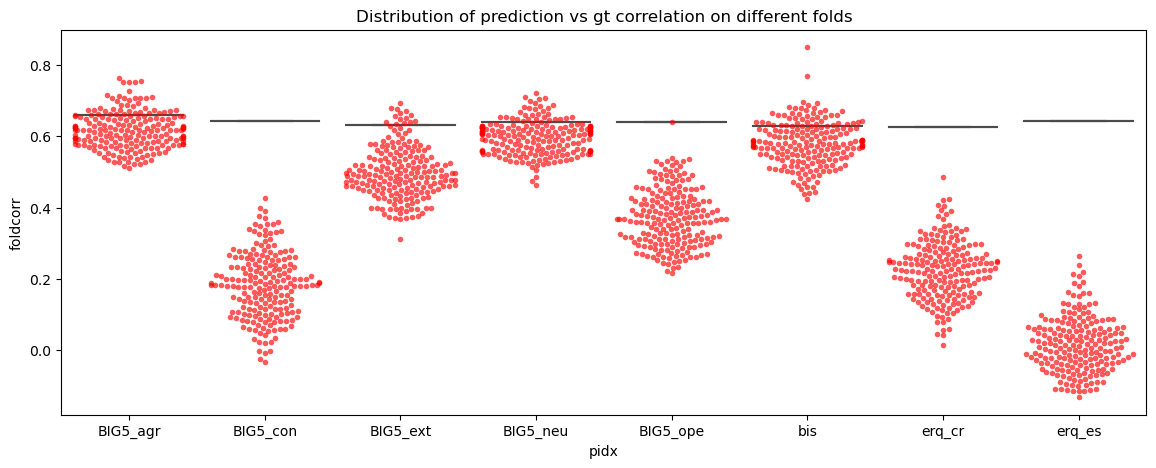

In [38]:
pal = sns.color_palette('hsv', len(row1))
plt.figure(figsize=(14,5))
# sns.barplot(x="pidx", y="foldcorr", data=pred_distrib, capsize=0.001, errorbar="sd", palette=pal, alpha=0.3)
sns.boxplot(x="pidx", y="foldcorr", data=null_distrib2.groupby('pidx').quantile(0.95).reset_index(), palette=pal)
sns.swarmplot(x="pidx", y="foldcorr", data=pred_distrib2, color="r", alpha=.65, size=4)
# sns.swarmplot(x="pidx", y="foldcorr", data=null_distrib, color="b", alpha=.65, size=4)
plt.title("Distribution of prediction vs gt correlation on different folds")
plt.show()

#### Ridge on Features (volume of each network)

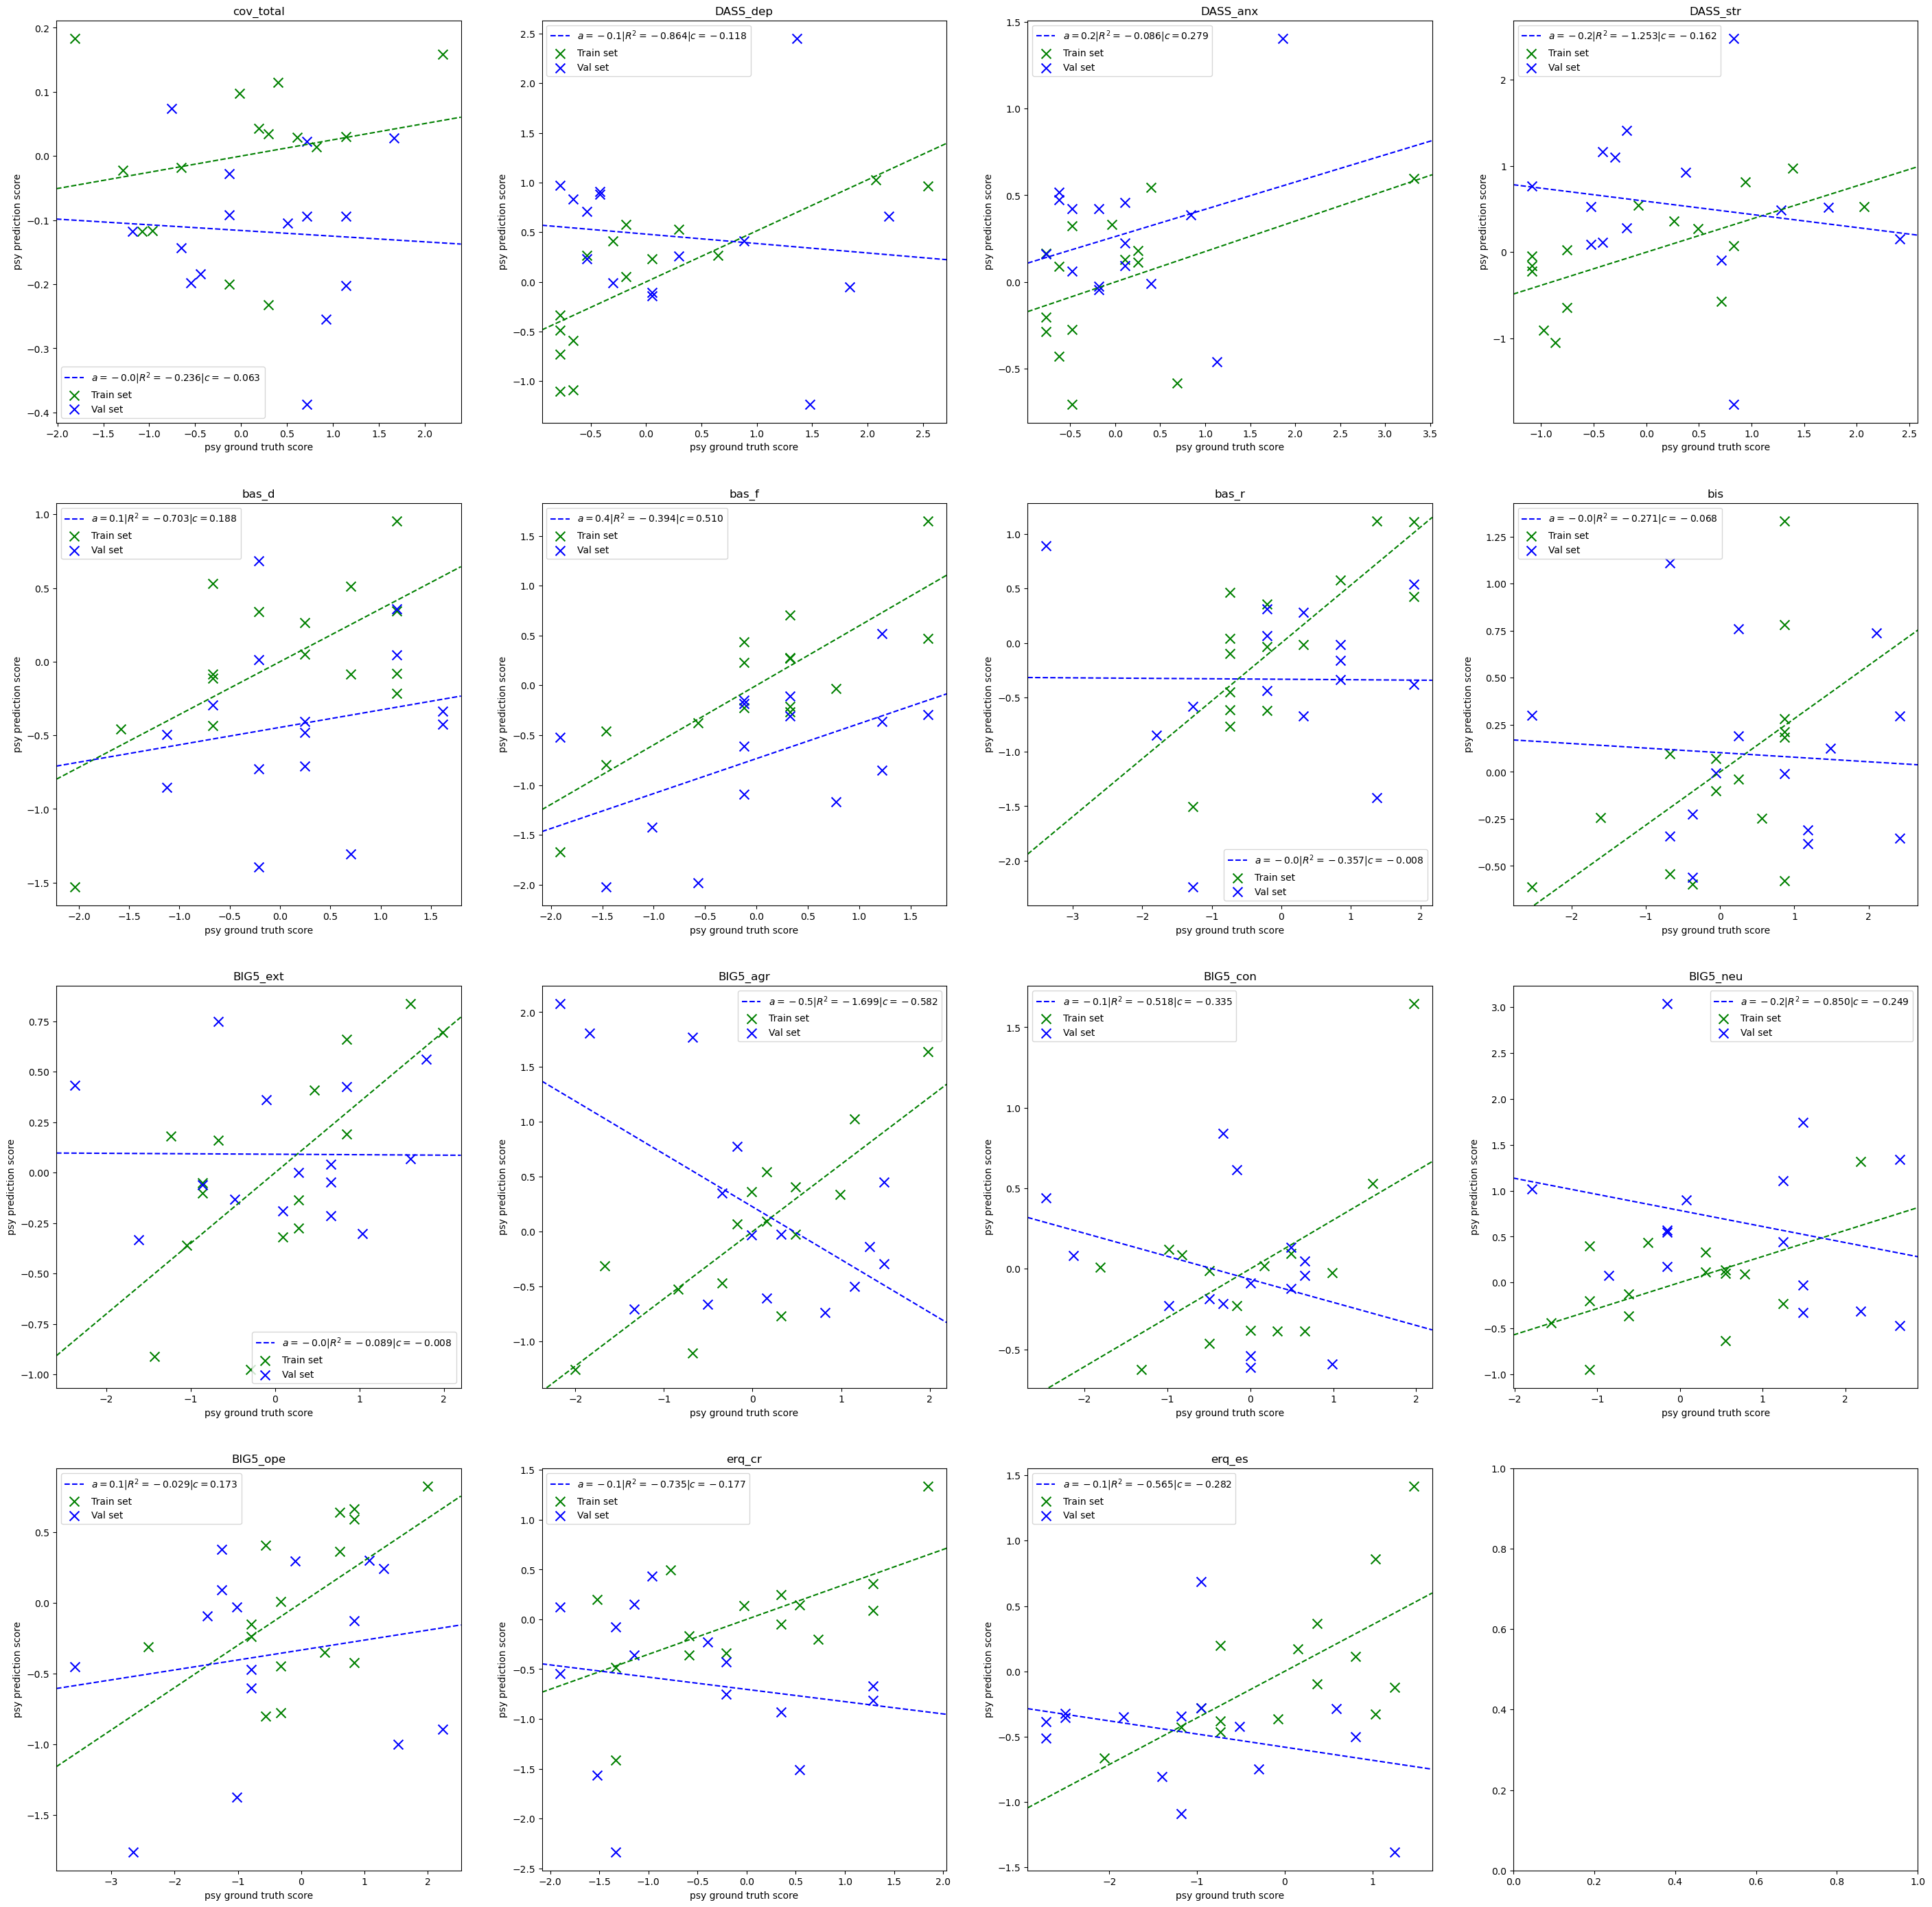

In [12]:
fig, ax   = plt.subplots(4,4, figsize=(35,35))
corr_grad = np.zeros((len(existing_psy)))
n = len(psyscore)
for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    
    # leave one out val prediction score
    j = 15
    clf  = Ridge(alpha=5)
    tmp  = psyscore[:j]
    tmp2 = features[:j]

    y, m, s = zscore(tmp, ret_param=True)
    clf.fit(tmp2, y)

    topredict = features[j:]
    gt   = (psyscore[j:]-m)/s

    pred1 = clf.predict(tmp2)
    pred2 = clf.predict(topredict)
    
    r2   = r2_score(gt,pred2)
    m1, b1 = np.polyfit(y, pred1, deg=1)
    m2, b2 = np.polyfit(gt, pred2, deg=1)
    corr   = stats.pearsonr(gt, pred2).statistic
    
    corr_grad[i] = corr
    ax[r,c].axline(xy1=(0, b1), linestyle='--', slope=m1, color='g')
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={corr:.3f}$', color='b')

    ax[r,c].scatter(y, pred1, s=100, marker='x', color='g', label="Train set")
    ax[r,c].scatter(gt, pred2, s=100, marker='x', color='b', label="Val set")
    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

#### Ridge on Features selected + (shuffling the elements)

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression

A = gradients[:,:,:1].reshape(30,-1)

100%|██████████| 15/15 [02:05<00:00,  8.39s/it]


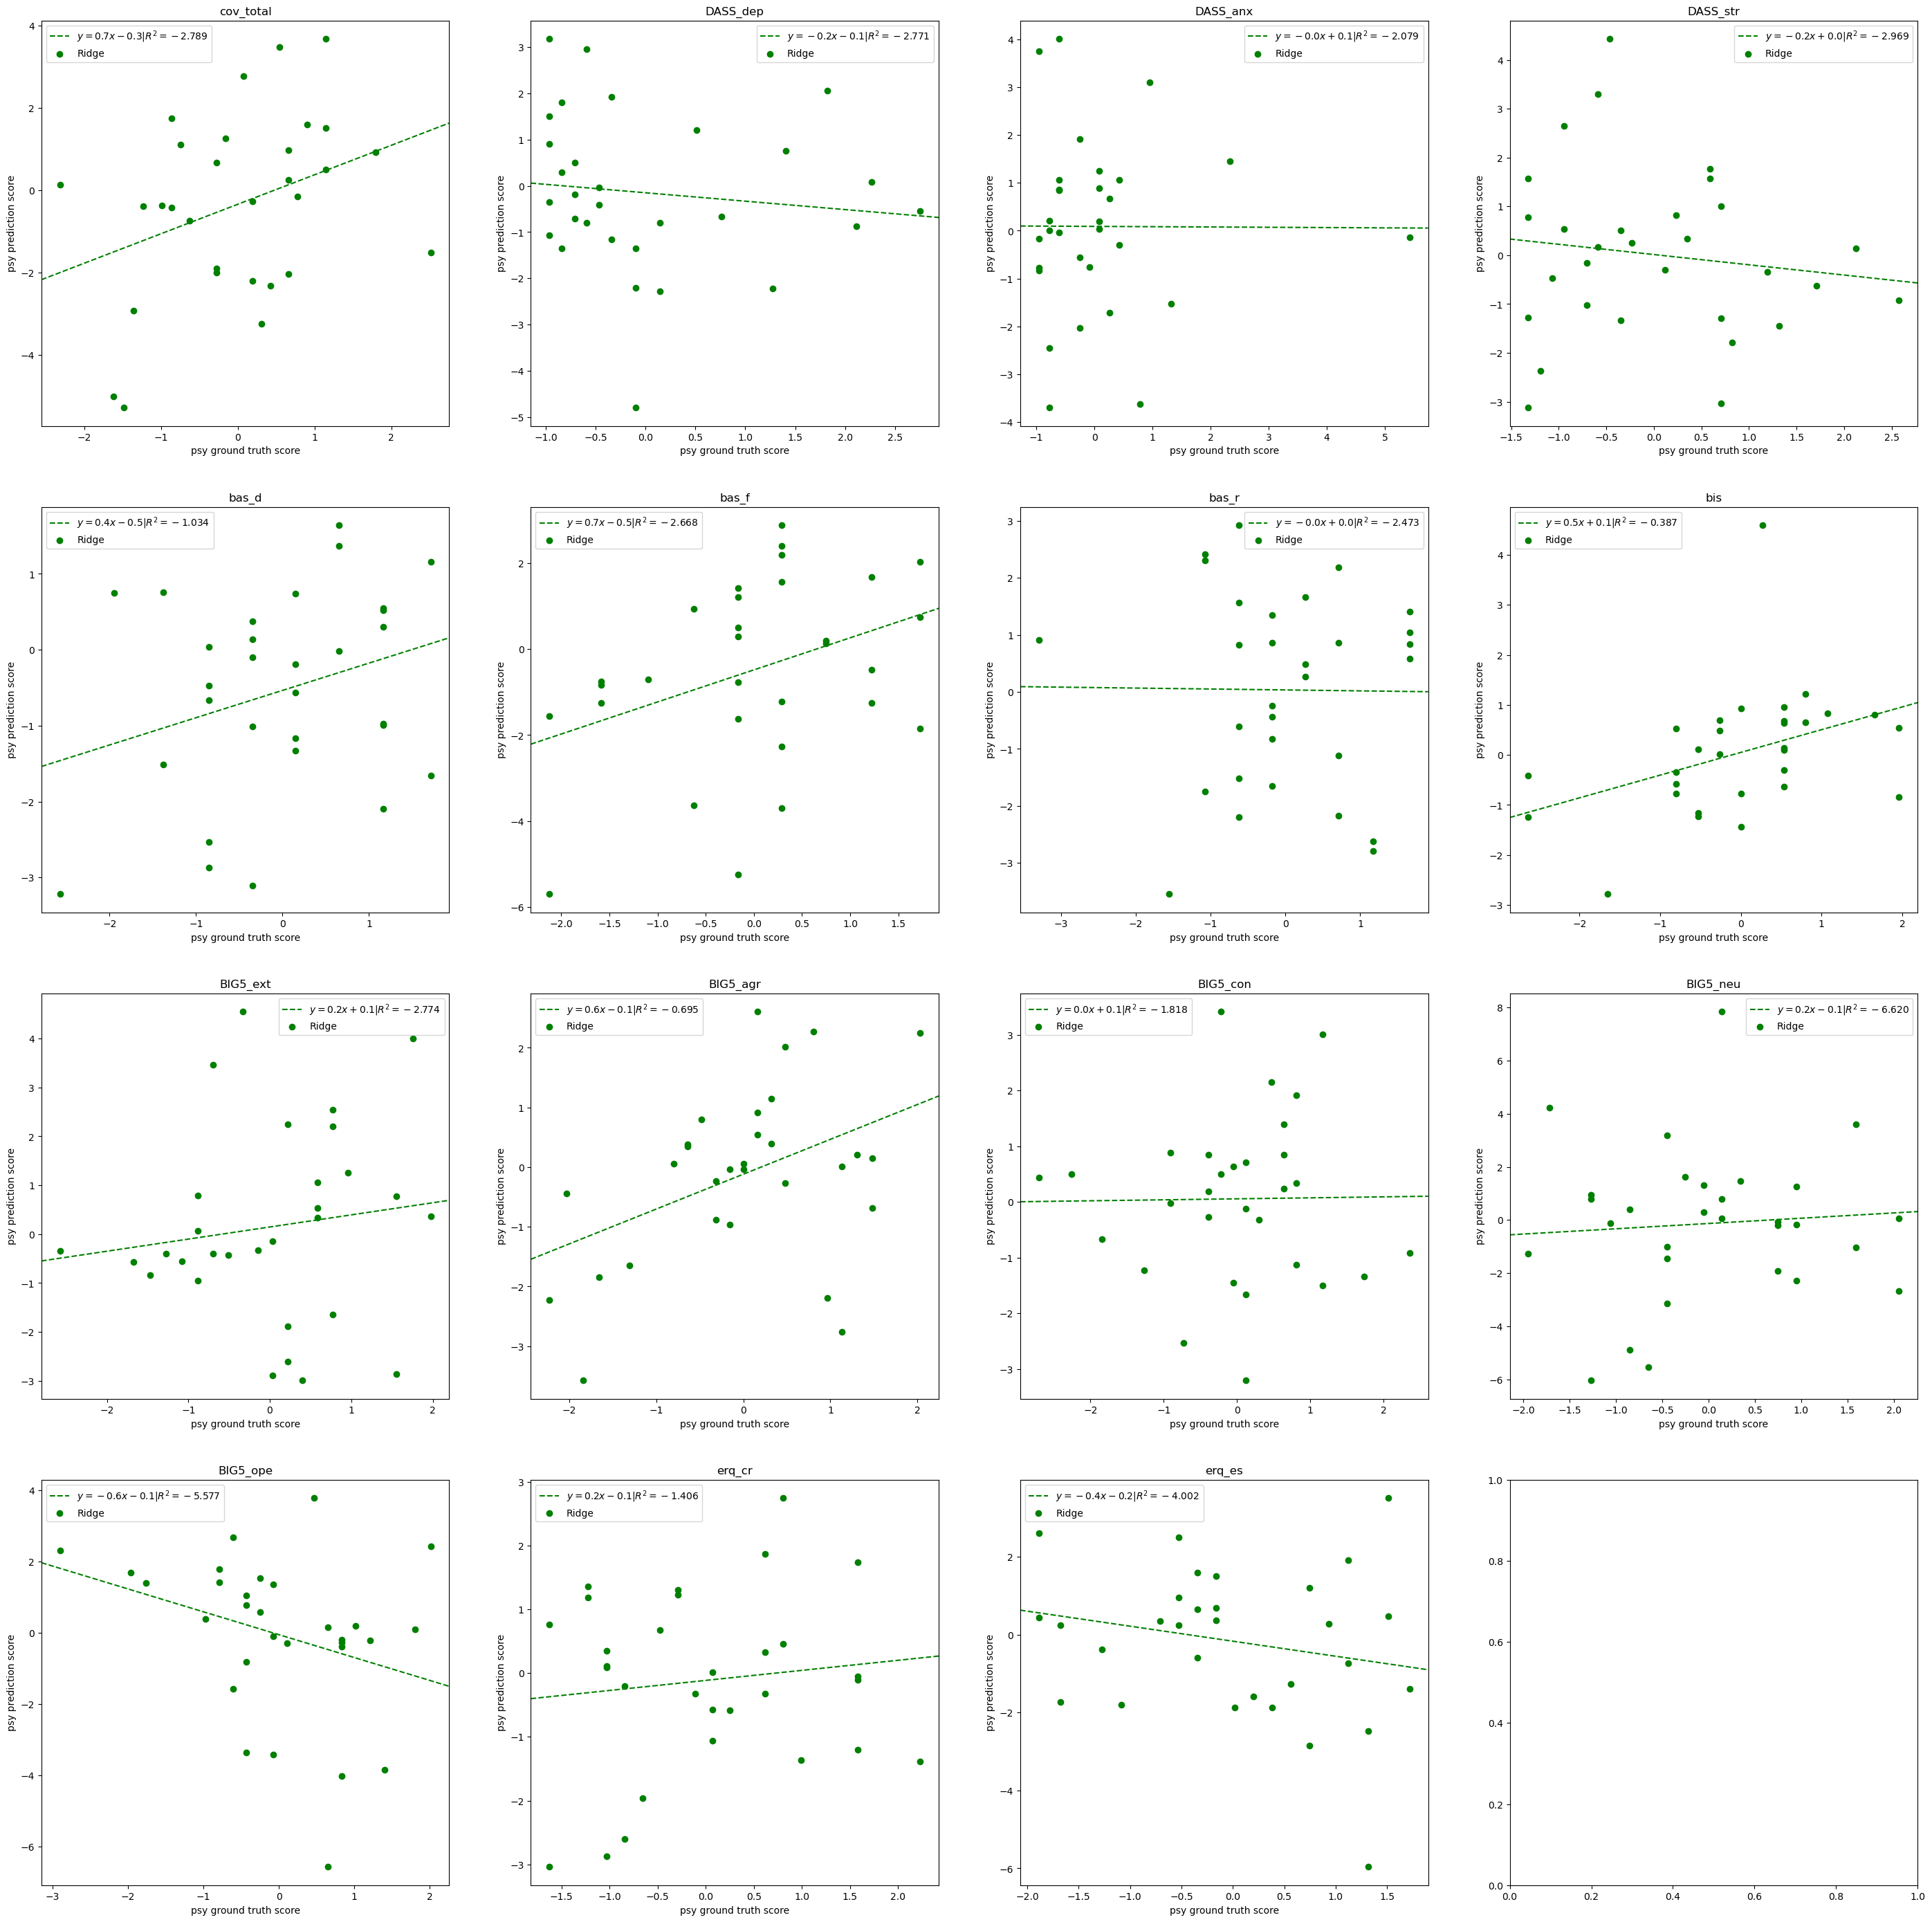

In [12]:
fig, ax = plt.subplots(4,4, figsize=(35,35))

logs = {k: {} for k in existing_psy}

for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    clf  = Ridge(alpha=1.0)

    # leave one out val prediction score    
    pts2 = []
    for i in range(len(psyscore)):
        # select number of percentile
        tmp  = np.concatenate([psyscore[:i], psyscore[i+1:]])
        tmp2 = np.concatenate([A[:i], A[i+1:]])

        selector = SelectPercentile(mutual_info_regression, percentile=10)
        selector.fit(tmp2, tmp)
        
        newfeatures = A[:,selector.get_support()]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2[:,selector.get_support()], y)

        # we log the coefficients and as well the 
        logs[feat][i] = [selector.get_support(), clf.coef_]

        topredict = newfeatures[i]
        gt = (psyscore[i]-m)/s

        pts2.append([clf.predict([topredict])[0], gt])
        
    pts2 = np.asarray(pts2)

    r2 = r2_score(pts2[:,1],pts2[:,0])
    m2, b2 = np.polyfit(pts2[:,1], pts2[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$y = {m2:.1f}x {b2:+.1f} | R^2={r2:.3f}$', color='g')

    ax[r,c].scatter(pts2[:,1], pts2[:,0], color='g', label="Ridge")

    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

In [48]:
pindx = 'bas_d'
selected_grads = np.zeros(400)
summed_coefs   = np.zeros(400)
for i in range(len(logs[pindx])):
    selected_grad, coefs = logs[pindx][i]
    selected_grads += selected_grad

    grad = np.zeros_like(selected_grad, dtype=float)
    c    = 0
    for k in range(len(grad)):
        if selected_grad[k] == True:
            grad[k] = np.abs(coefs[c])
            c += 1
    summed_coefs += grad

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


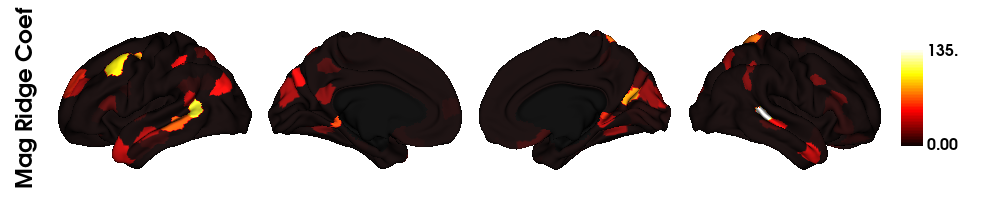

In [49]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

grad_map = map_to_labels(summed_coefs * selected_grads, labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad_map, size=(1000, 200), cmap='hot',
                 color_bar=True, label_text=['Mag Ridge Coef'], zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


In [37]:
# For best model for ridge / number of features found above 
# We try to shuffle the dataset and refit to see prediction strength

j = 20 # We fix the split to be 20 and split it the same way all the time

C = np.zeros((len(existing_psy), 100))
for i in tqdm(range(len(existing_psy))):
    indices = np.arange(0,30)
    for n in range(20):
        np.random.shuffle(indices)

        k    = psy_k[i]
        feat = existing_psy[i]

        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        psyscore = np.array(psyscore)

        selector = SelectKBest(mutual_info_regression, k=k)
        selector.fit(A[indices[:j]], psyscore[indices[:j]])
        newfeatures = A[:,selector.get_support()]

        clf  = Ridge(alpha=1)
        tmp  = psyscore[indices[:j]]
        tmp2 = newfeatures[indices[:j]]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = newfeatures[indices[j:]]
        gt   = (psyscore[indices[j:]]-m)/s

        pred2  = clf.predict(topredict)
        corr   = stats.pearsonr(gt, pred2).statistic
        C[i,n] = corr

100%|██████████| 15/15 [02:33<00:00, 10.25s/it]


Test distribution

In [44]:
np.random.seed(99)
distribsA = []
n = len(psyscore)
j = 20
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    psyscore = np.array(psyscore)
    selector = SelectKBest(mutual_info_regression, k=psy_k[i])
    selector.fit(A[:j], psyscore[:j])
    newfeatures = A[:,selector.get_support()]    
    
    null_distrib = []
    for _ in range(1000):
        np.random.shuffle(psyscore)

        clf  = Ridge(alpha=1)
        tmp  = psyscore[:j]
        tmp2 = newfeatures[:j]

        y, m, s = zscore(tmp, ret_param=True)
        clf.fit(tmp2, y)

        topredict = newfeatures[j:]

        gt = (psyscore[j:]-m)/s
    
        pred = clf.predict(topredict)
        corr   = stats.pearsonr(pred, gt).statistic
        null_distrib.append(corr)
    distribsA.append(null_distrib)

100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


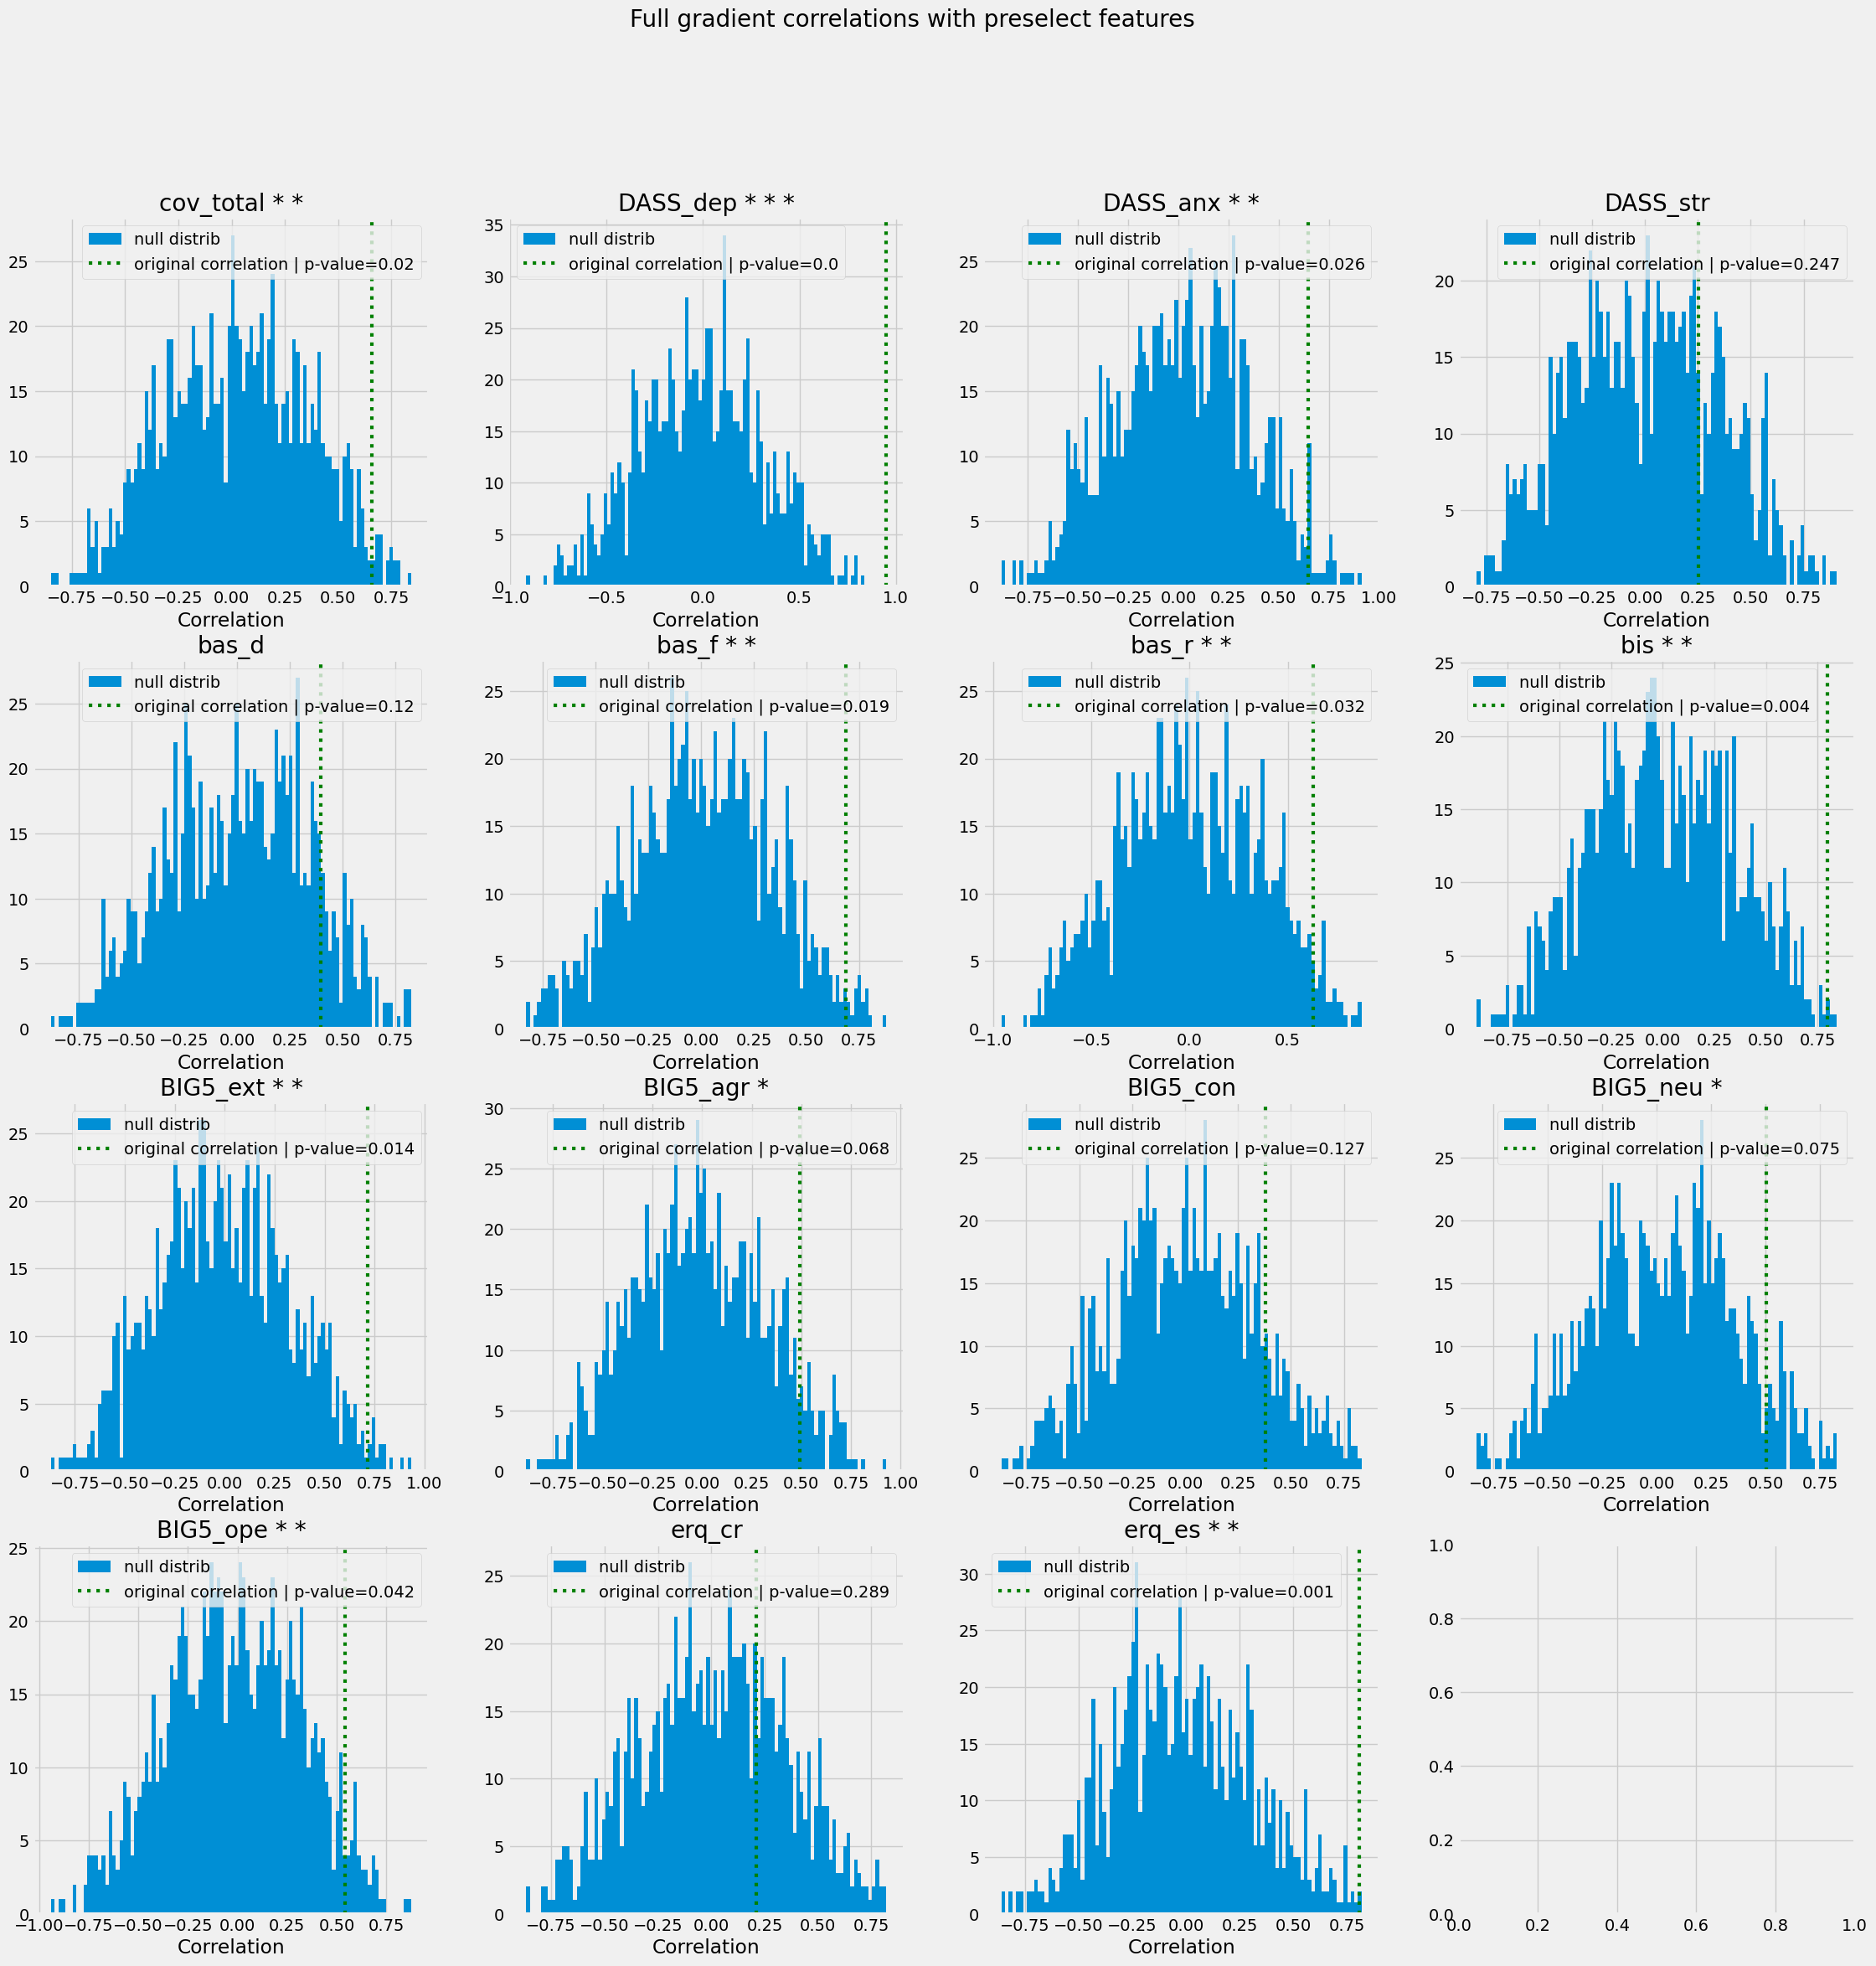

In [46]:
fig, ax = plt.subplots(4,4, figsize=(25,25))

for i in range(len(existing_psy)):
    feat = existing_psy[i]
    r,c = i //4, i % 4
    pval = null_score(distribsA[i], corr_grad[i])
    ax[r,c].hist(distribsA[i],bins=100, label='null distrib')

    if corr_grad[i] >= 0:
        ax[r,c].axvline(x=corr_grad[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format(pval))
        nbstar = int(pval < 0.05) + int(pval < 0.1) + int(pval < 0.001)
        ax[r,c].set_title(feat + ' *'*nbstar)
    else:
        ax[r,c].axvline(x=corr_grad[i], c='g', linestyle='dotted', linewidth=3, label='original correlation | p-value={}'.format("negcorr"))
        ax[r,c].set_title(feat)

    ax[r,c].set_xlabel('Correlation')
    ax[r,c].legend()

plt.suptitle('Full gradient correlations with preselect features', size=20)
plt.show()

### Regression with PCA featured on train

In [52]:
# Loading gradients 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad.pkl')
subjects     = list(subject_grad.keys())
gradients = np.asarray([subject_grad[s] for s in subjects])

In [53]:
from sklearn.decomposition import PCA

100%|██████████| 15/15 [03:03<00:00, 12.22s/it]


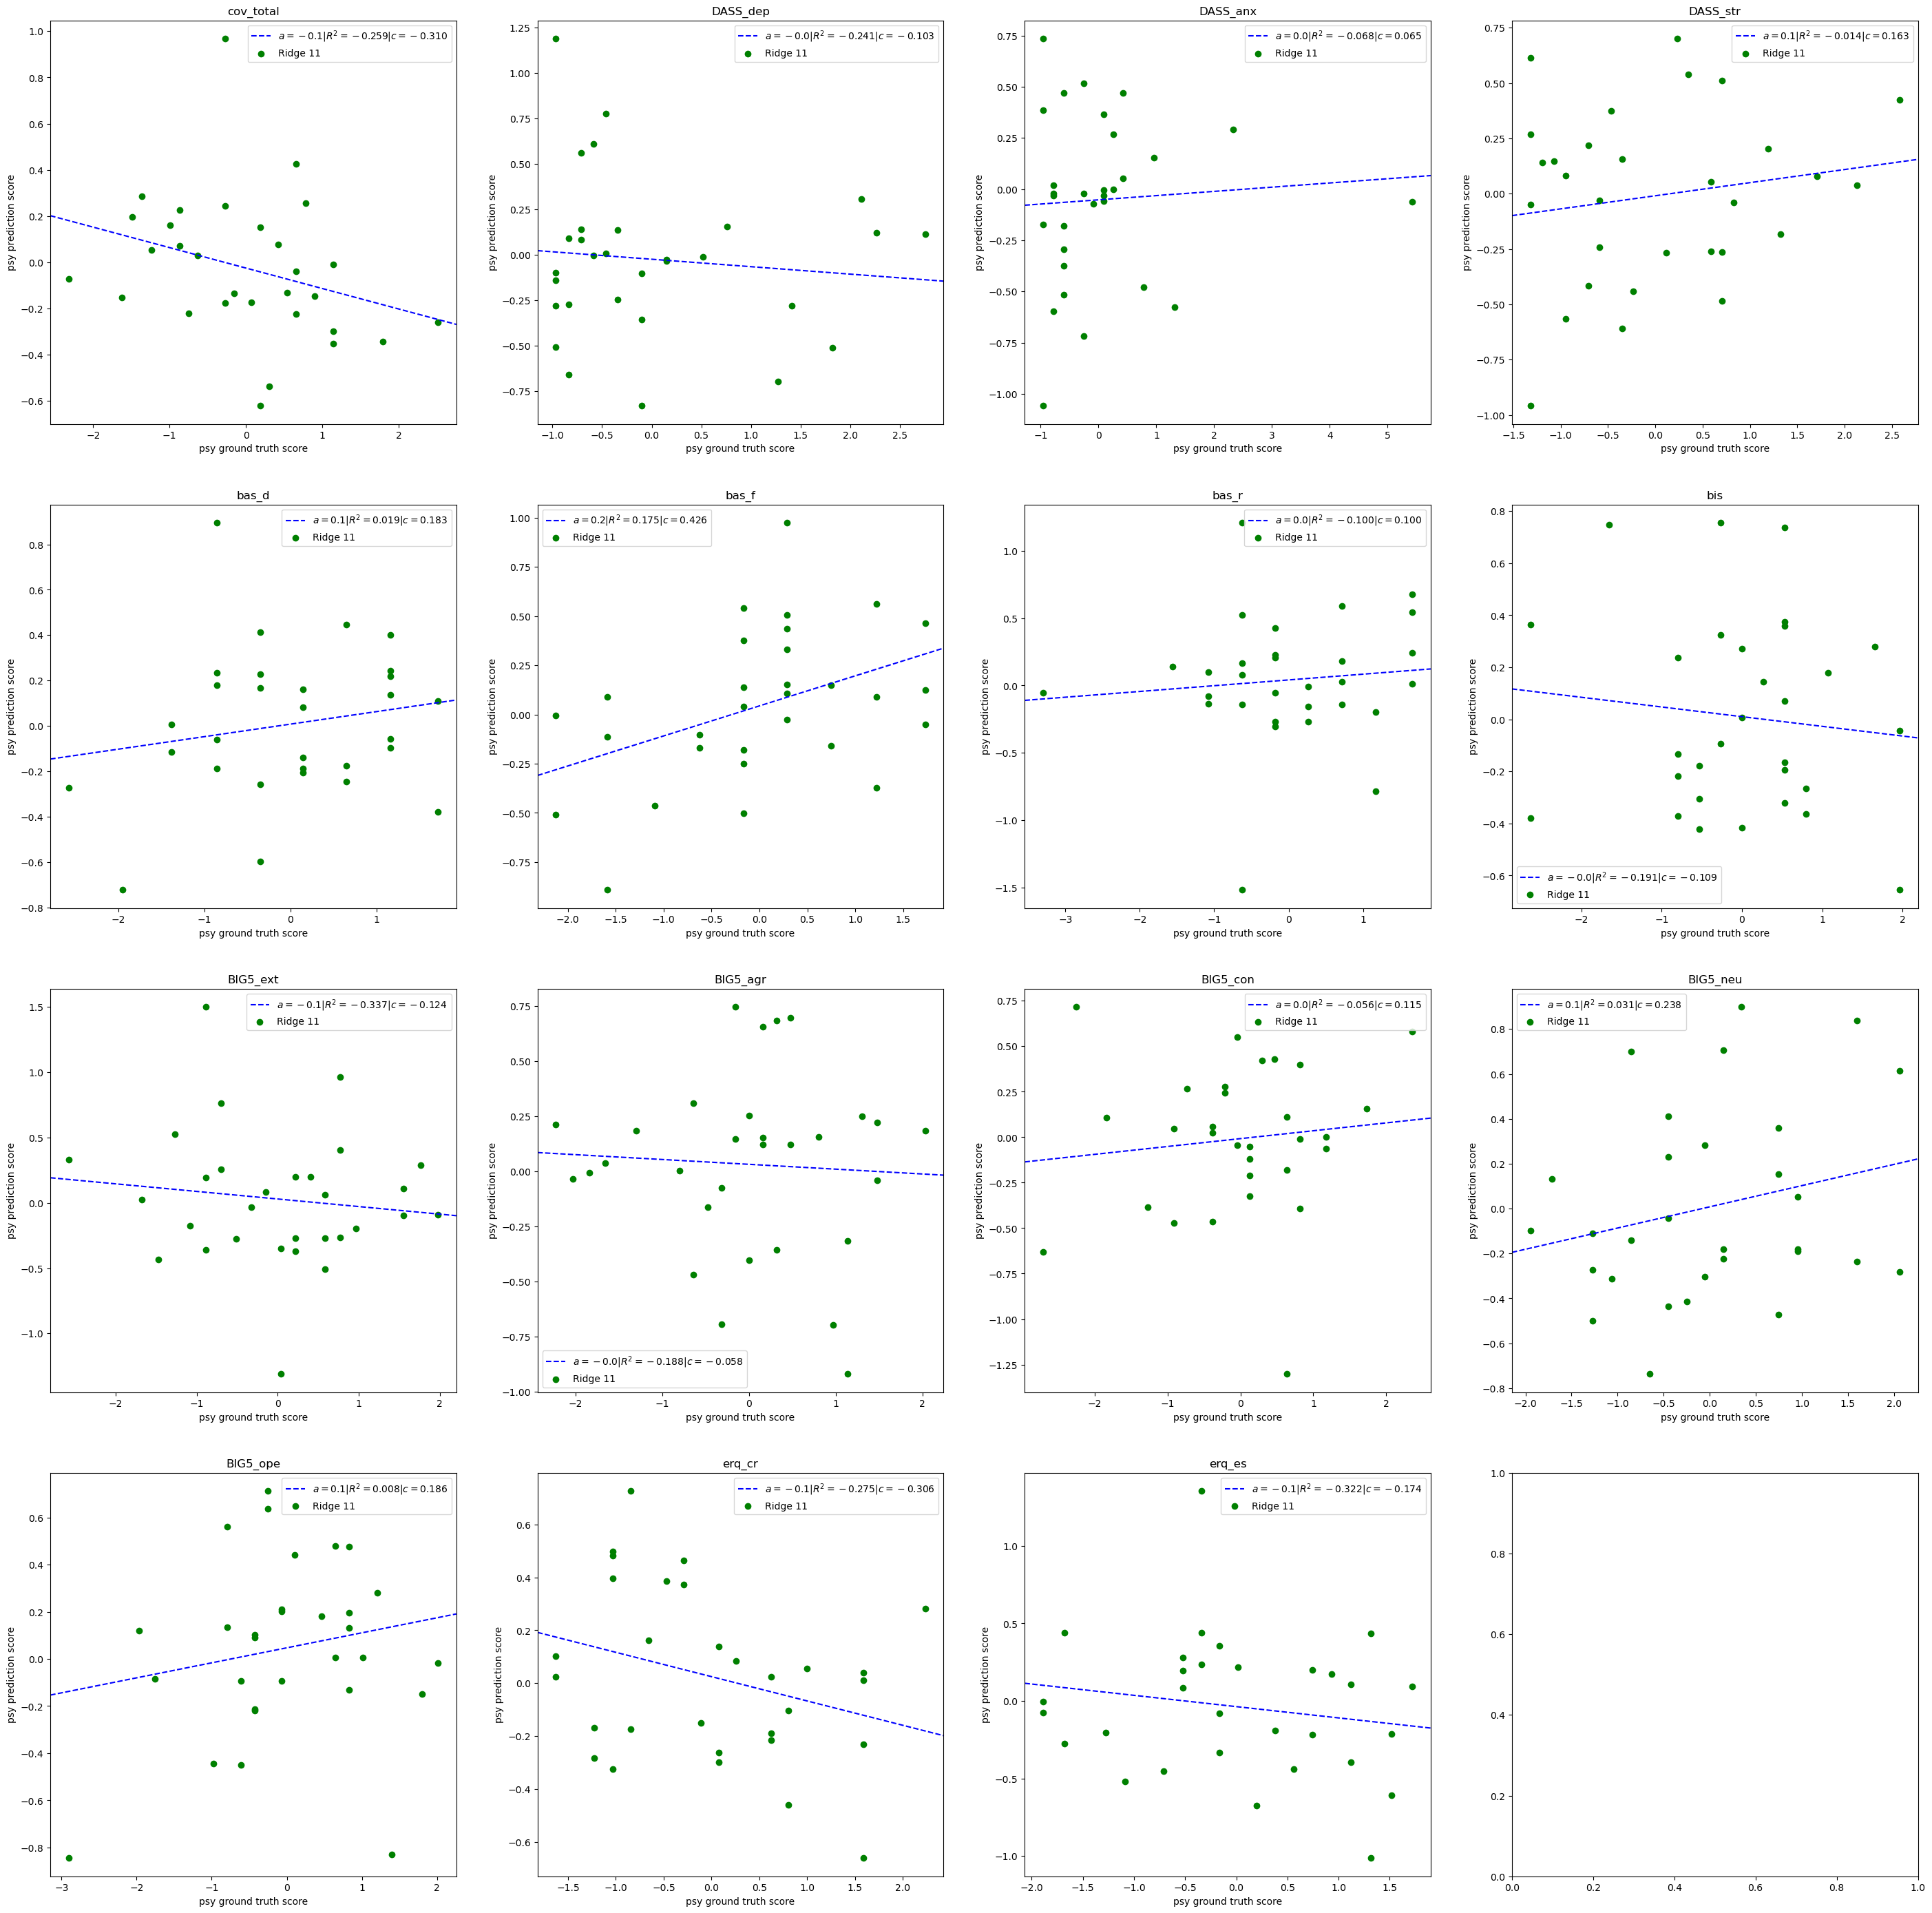

In [65]:
logs  = {}
lambdas = [0.5,1] +[i/10 for i in range(10,31,1)]
A     = gradients.reshape(30,-1)
fig, ax = plt.subplots(4,4, figsize=(35,35))


for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]
    r,c = i //4, i % 4

    psyscore = [behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))]
    psyscore = np.array(psyscore)

    best_corr = -1
    pts = []
    for a in lambdas:
        clf  = Ridge(alpha=a)
        # leave one out val prediction score    
        pts2 = []
        for j in range(len(psyscore)):
            ncomb    = 10
            cur_expl = 0
            # select number of percentile
            tmp  = np.concatenate([psyscore[:j], psyscore[j+1:]])
            tmp2 = np.concatenate([A[:j], A[j+1:]])

            while cur_expl < 0.8:
                pca  = PCA(n_components=ncomb)
                pca.fit(tmp2)
                cur_expl = np.sum(pca.explained_variance_ratio_)
                ncomb += 1
            tmp2 = pca.transform(tmp2)

            y, m, s = zscore(tmp, ret_param=True)
            clf.fit(tmp2, y)

            topredict = pca.transform([A[j]])
            gt = (psyscore[j]-m)/s

            pts2.append([clf.predict(topredict)[0], gt])
            
        pts2 = np.asarray(pts2)

        cur_corr   = stats.pearsonr(pts2[:,0], pts2[:,1]).statistic
        if cur_corr > best_corr:
            best_corr = cur_corr
            pts = deepcopy(pts2)
            logs[feat] = clf.coef_

        # we log the coefficients and as well the 
        
    r2 = r2_score(pts[:,1],pts[:,0])
    m2, b2 = np.polyfit(pts[:,1], pts[:,0], deg=1)
    
    ax[r,c].axline(xy1=(0, b2), linestyle='--', slope=m2, label=f'$a = {m2:.1f} | R^2={r2:.3f} | c={best_corr:.3f}$', color='b')

    ax[r,c].scatter(pts[:,1], pts[:,0], color='g', label="Ridge {}".format(np.sum(logs[feat] != 0)))

    ax[r,c].set_title("{}".format(feat))
    ax[r,c].set_xlabel("psy ground truth score")
    ax[r,c].set_ylabel("psy prediction score")
    ax[r,c].legend()

### Mix prediction with movies 

In [118]:
import warnings
warnings.filterwarnings("ignore")

In [126]:
np.random.seed(10)
movies = os.listdir('./resources/static_grad/individual_level/')
feat   = existing_psy[7]

corrs = []
for _ in tqdm(range(1000)):
    trainmovie = np.random.choice(movies, 10, replace=False)
    valmovie   = list(set(movies) - set(trainmovie))
    trainsubjects = np.random.choice(list(subject_grad.keys()), 20, replace=False)
    valsubjects   = list(set(list(subject_grad.keys())) - set(trainsubjects))

    ref = load('./resources/static_grad/group_level/Rest_group_grad.pkl')[:,:2]
    trainData = []
    for mov in trainmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in trainsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in trainsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        trainData   += data

    valData  = []
    for mov in valmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in valsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in valsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        valData     += data

    clf   = Lasso(alpha=1)
    trainY, trainX = np.asarray(trainData).T
    valY, valX     = np.asarray(valData).T

    trainX = np.stack(trainX)
    valX   = np.stack(valX)
    trainY = np.array([behavioural[behavioural.ID == trainY[i]][feat].item() for i in range(len(trainY))])
    valY   = np.array([behavioural[behavioural.ID == valY[i]][feat].item() for i in range(len(valY))])

    trainY, m, s = zscore(trainY, ret_param=True)

    valY   = (valY-m)/s

    clf.fit(trainX, trainY)
    pred = clf.predict(valX)
    corr = stats.pearsonr(pred, valY).statistic
    corrs.append(corr)


100%|██████████| 1000/1000 [01:51<00:00,  8.98it/s]


In [127]:
np.random.seed(10)
movies = os.listdir('./resources/static_grad/individual_level/')
feat   = existing_psy[7]

nullcorrs = []
for _ in tqdm(range(1000)):
    trainmovie = np.random.choice(movies, 10, replace=False)
    valmovie   = list(set(movies) - set(trainmovie))
    trainsubjects = np.random.choice(list(subject_grad.keys()), 20, replace=False)
    valsubjects   = list(set(list(subject_grad.keys())) - set(trainsubjects))

    ref = load('./resources/static_grad/group_level/Rest_group_grad.pkl')[:,:2]
    trainData = []
    for mov in trainmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in trainsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in trainsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        trainData   += data

    valData  = []
    for mov in valmovie:
        subject_grad = load('./resources/static_grad/individual_level/{}'.format(mov))
        tmp_grad     = procrustes_align([subject_grad[s][:,:2] for s in subjects if s in valsubjects], ref=ref)[0]
        subjects     = list(subject_grad.keys())
        data = []
        c = 0
        for s in subjects:
            if s in valsubjects:
                data.append((s, tmp_grad[c][:,0]))
                c += 1
        valData     += data

    clf   = Lasso(alpha=1)
    trainY, trainX = np.asarray(trainData).T
    valY, valX     = np.asarray(valData).T

    trainX = np.stack(trainX)
    valX   = np.stack(valX)
    trainY = np.array([behavioural[behavioural.ID == trainY[i]][feat].item() for i in range(len(trainY))])
    valY   = np.array([behavioural[behavioural.ID == valY[i]][feat].item() for i in range(len(valY))])
    np.random.shuffle(trainY)
    np.random.shuffle(valY)

    trainY, m, s = zscore(trainY, ret_param=True)

    valY   = (valY-m)/s

    clf.fit(trainX, trainY)
    pred = clf.predict(valX)
    corr = stats.pearsonr(pred, valY).statistic
    nullcorrs.append(corr)


100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


(array([ 1.,  8., 24., 42., 57., 71., 69., 42., 13.,  6.]),
 array([-0.49896097, -0.40595678, -0.31295258, -0.21994839, -0.1269442 ,
        -0.03394   ,  0.05906419,  0.15206838,  0.24507258,  0.33807677,
         0.43108097]),
 <BarContainer object of 10 artists>)

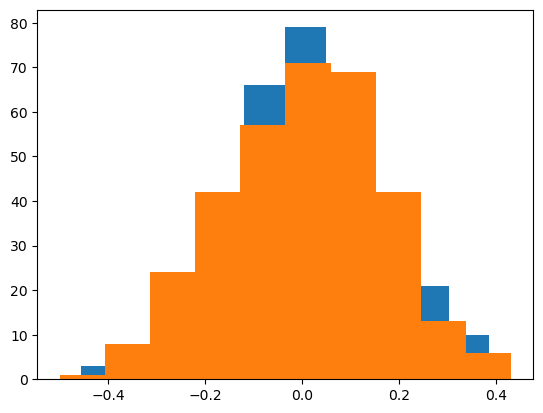

In [129]:
plt.hist(corrs)
plt.hist(nullcorrs)

### Multi-variate ridge

In [114]:
logs = {}
lambdas = [0.5,1] +[i/10 for i in range(10,31,1)]
A = gradients.reshape(30,-1)

pscores = []
for i in tqdm(range(len(existing_psy))):
    feat = existing_psy[i]

    psyscore = np.array([behavioural[behavioural.ID == subjects[s]][feat].item() for s in range(len(subjects))])
    pscores.append(psyscore)
    # pscores.append(zscore(psyscore))
pscores = np.asarray(pscores)

100%|██████████| 15/15 [00:00<00:00, 63.80it/s]


In [115]:
trainX, valX = A[:20], A[20:]
trainY, valY = pscores.T[:20], pscores.T[20:]

In [118]:
clf  = Lasso(alpha=5)

clf.fit(trainX, trainY)

pred = clf.predict(valX)


100%|██████████| 15/15 [00:00<00:00, 1664.27it/s]


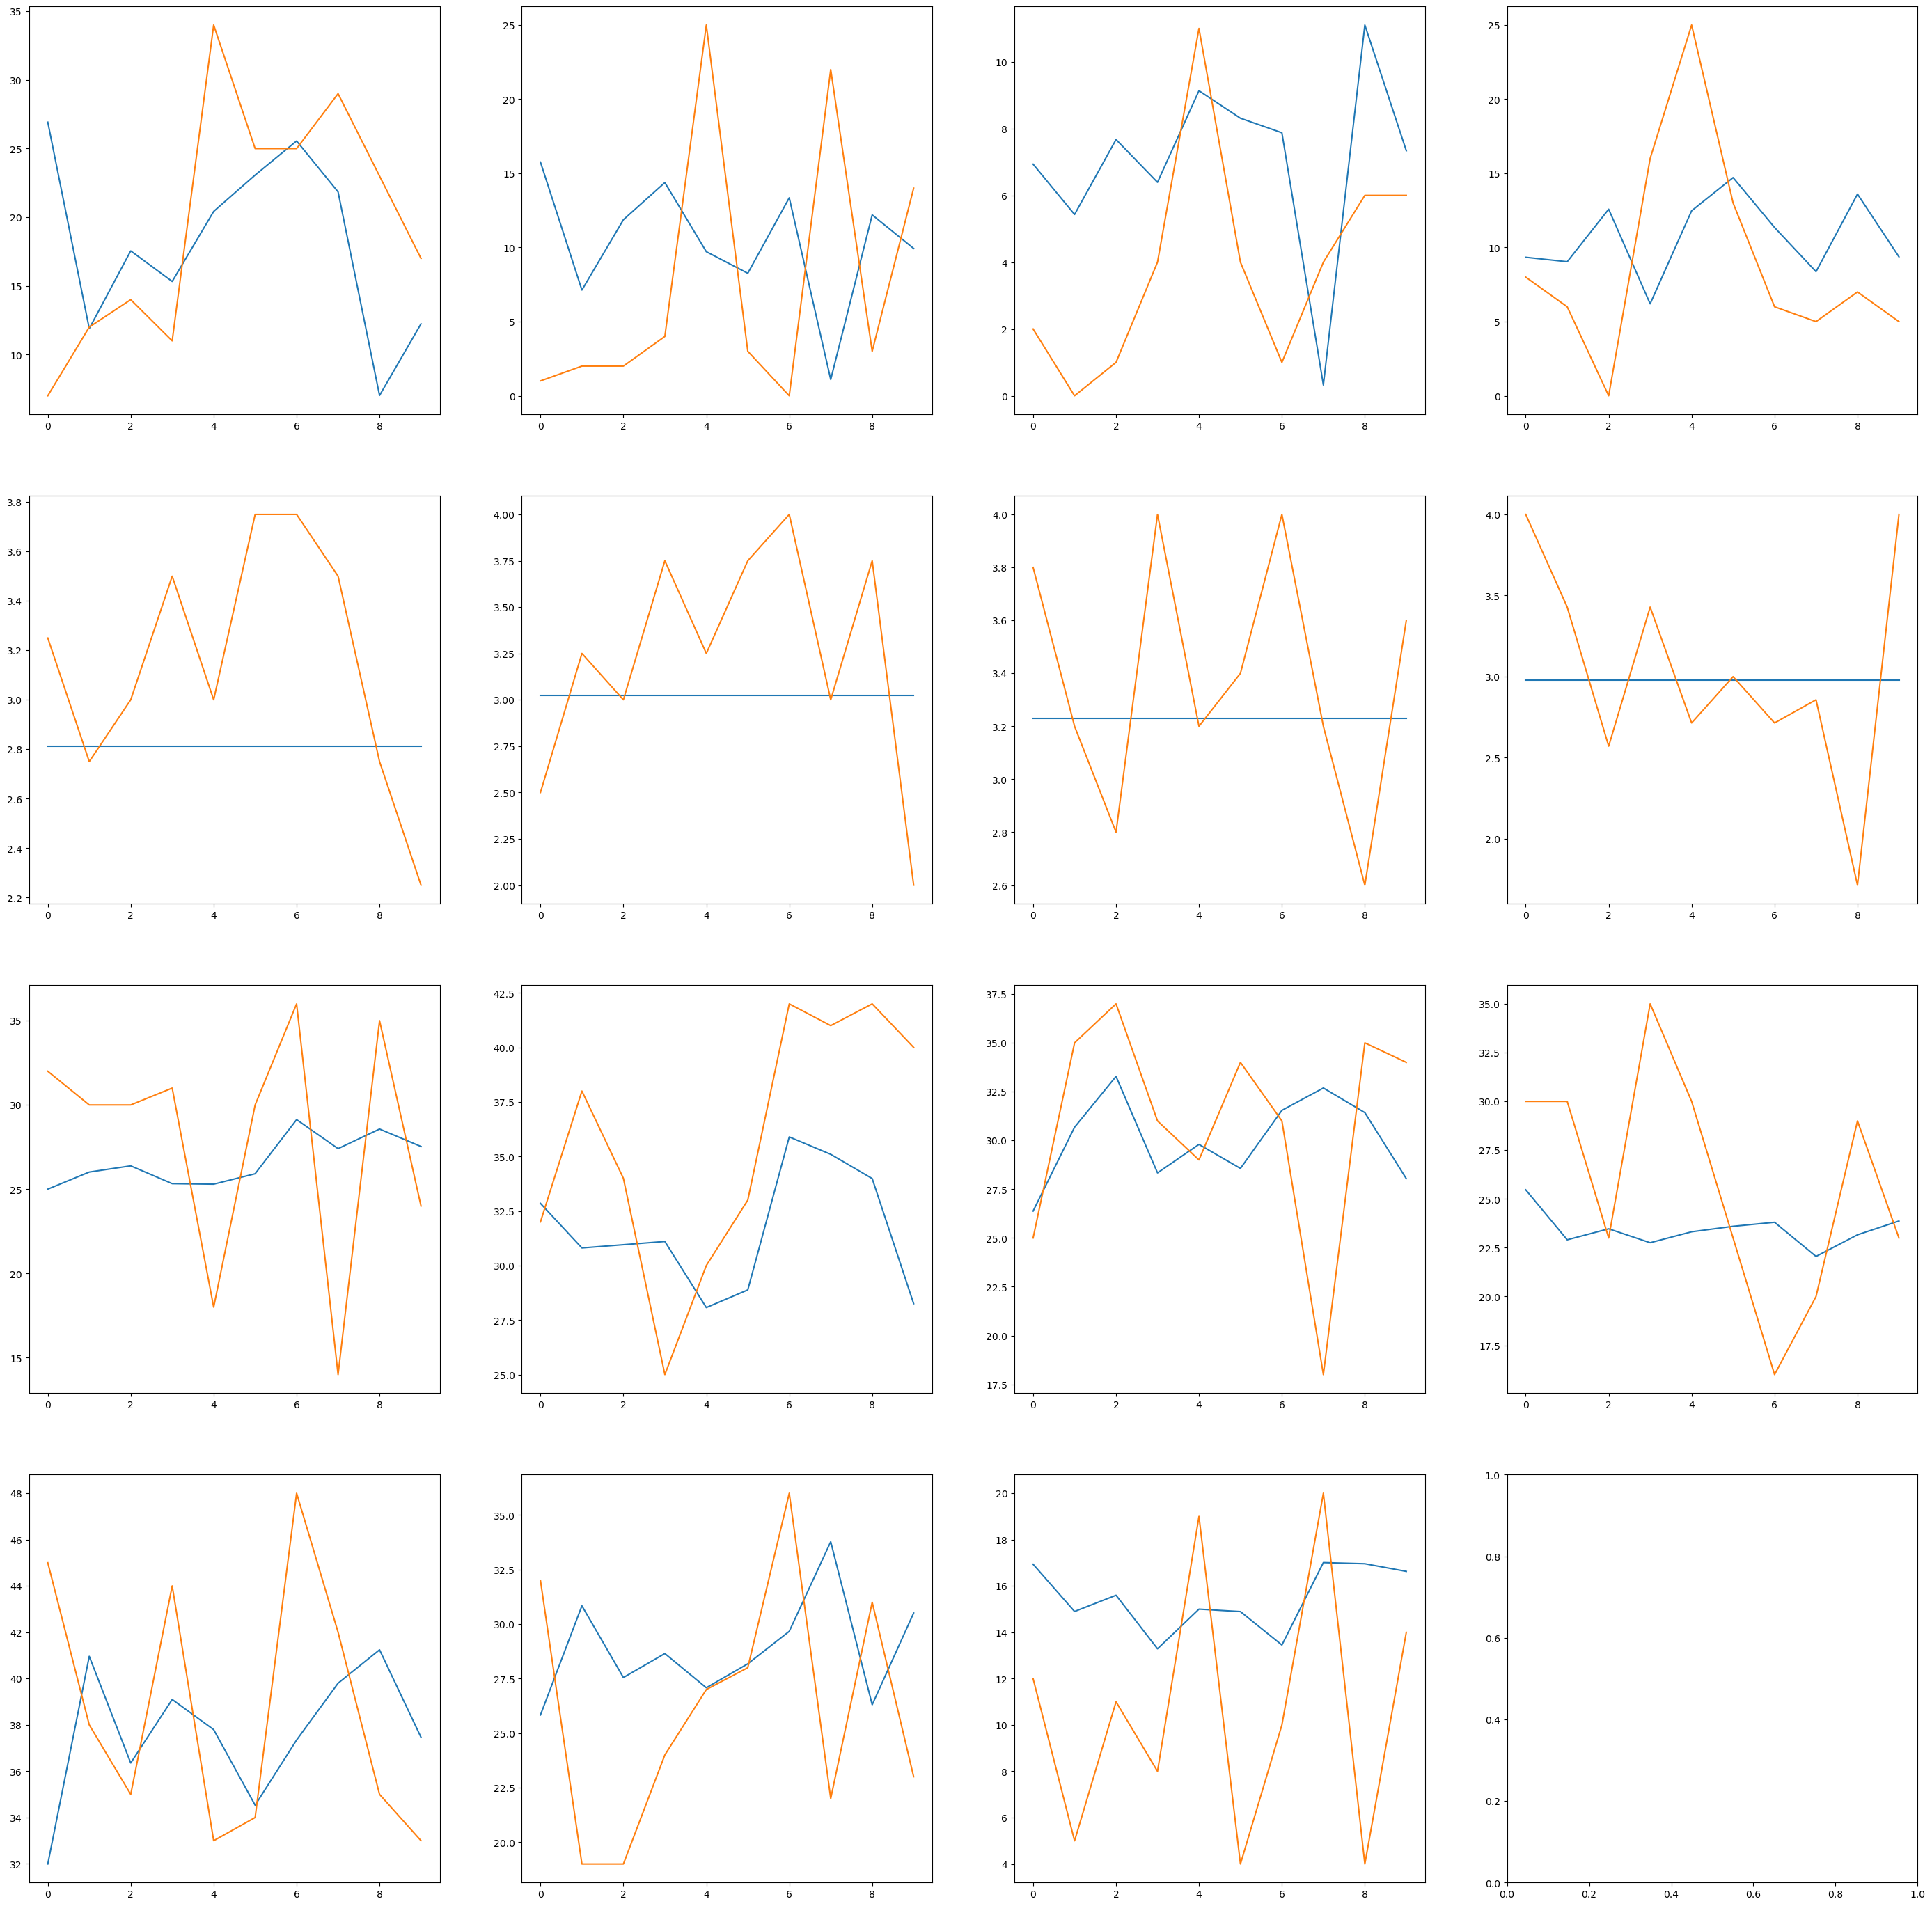

In [119]:
fig, ax = plt.subplots(4,4, figsize=(35,35))


for i in tqdm(range(len(existing_psy))):
    r,c = i //4, i % 4
    ax[r,c].plot(pred[:,i])
    ax[r,c].plot(valY[:,i])

## On Dynamic Gradients

In [72]:
# Loading gradients 
subject_grad = load('./resources/dynamic_grad/individual_level/Rest_40_grad.pkl')
subjects     = list(subject_grad.keys())

In [82]:
subject_grad['S17'][0].shape

(343, 400, 10)